# Лабораторная работа №4

## Анализ данных с помощью метода главных компонент 

Рассмотрим влияние снижения размерности данных, достигаемое использованием [`PCA-трансформации`](https://ru.wikipedia.org/wiki/Метод_главных_компонент) на качество работы классифицирующей модели (в данном случае мы будем использовать [`ExtraTreesClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html))

В качестве датасета будем использовать данные, содержащие информацию о различных характеристиках лесного покрова с целью предсказания его типа (всего 7 классов, представленных числами от 0 до 6). Возможные варианты:

- Ель/Пихта;
- Сосна остистая;
- Сосна жёлтая;
- Тополь/Ива;
- Осина;
- Псевдотсуга Мензиса;
- Криволесье.


Набор данных доступен на [Kaggle](https://www.kaggle.com/datasets/uciml/forest-cover-type-dataset).

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import random

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

Для воспроизводимости экспериментов

In [3]:
random.seed(42)
np.random.seed(42)

Определим ряд полезных функций, поскольку мы планируем работать в ядре Kaggle

Набор функций визуализации

In [4]:
def plot_numeric_columns_distributions(data: pd.DataFrame, columns, plots_in_row, plot_width):
    n_cols = len(columns)
    n_rows = int(np.ceil(n_cols / plots_in_row))

    fig, axes = plt.subplots(n_rows, plots_in_row, figsize=(plot_width * plots_in_row, plot_width * n_rows))

    for i, col in enumerate(columns):
        row_idx = i // plots_in_row
        col_idx = i % plots_in_row
        sns.histplot(data[col], ax=axes[row_idx, col_idx], kde=True, stat="density")

        axes[row_idx, col_idx].set_title(f"Distribution Plot of {col}")
        axes[row_idx, col_idx].set_xlabel(col)

    for i in range(n_cols, n_rows * plots_in_row):
        fig.delaxes(axes.flatten()[i])

    fig.tight_layout()

    plt.show()


def plot_categories_histograms(data: pd.DataFrame, columns):
    for column in columns:
        plt.figure(figsize=(16, 6))
        sns.countplot(data=data, x=column)
        plt.title(f"Histogram for {column} column")
        plt.show()


def plot_pca_cumulative_variance(variance_ratio: np.array):
    cumulative_variance_ratio = np.cumsum(variance_ratio)
    plt.plot(cumulative_variance_ratio)
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance Ratio')
    plt.title('Cumulative Variance vs. Number of Principal Components')
    plt.show()

Оценка качества модели на тестовых данных

In [5]:
def evaluate_model(model, test_data, ground_truth):
    predictions = model.predict(test_data)
    f1 = f1_score(ground_truth, predictions, average='macro')
    accuracy = accuracy_score(ground_truth, predictions)
    cr = classification_report(ground_truth, predictions)
    cm = confusion_matrix(ground_truth, predictions)
    return {'macro_f1': f1, 'accuracy': accuracy}, cr, cm

Работа с PCA-компонентами

In [6]:
def generate_pca_report(pca: PCA, columns: np.array):
    return pd.DataFrame(pca.components_, columns=columns)


def print_pca_components_with_feature_importance(pca: PCA, report: pd.DataFrame, num_components_display=None,
                                                 num_features_display=None):
    components = pca.components_
    num_components_display = len(components) if num_components_display is None else min(len(components),
                                                                                        num_components_display)
    for i in range(num_components_display):
        displaying_component = report.iloc[i]
        sorted_component = displaying_component.abs().sort_values(ascending=False)
        top_features = sorted_component if num_features_display is None else sorted_component.head(num_features_display)
        print(f"Top features for PCA Component {i + 1}:")
        print(top_features)
        print()

# Загрузка и первичный анализ данных

In [7]:
data_path = 'data/covtype.csv'

In [8]:
data = pd.read_csv(data_path)
data.sample(10)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
250728,3351,206,27,726,124,3813,192,252,180,2271,...,0,0,0,0,0,0,1,0,0,1
246788,2732,129,7,212,1,1082,231,236,137,912,...,0,0,0,0,0,0,0,0,0,2
407714,2572,24,9,201,25,957,216,222,142,2191,...,0,0,0,0,0,0,0,0,0,2
25713,2824,69,13,417,39,3223,233,214,110,6478,...,0,0,0,0,0,0,0,0,0,2
21820,2529,84,5,120,9,1092,227,231,139,4983,...,0,0,0,0,0,0,0,0,0,2
251274,2050,284,42,170,141,192,75,201,246,255,...,0,0,0,0,0,0,0,0,0,3
52354,3004,236,5,960,95,5814,211,244,171,5713,...,0,0,0,0,0,0,0,0,0,2
246168,3232,111,10,541,78,1342,237,229,122,2270,...,0,0,0,0,0,0,1,0,0,1
477113,3141,156,6,503,72,240,228,241,147,1354,...,0,0,0,0,0,0,0,0,0,2
78834,2524,36,7,30,3,630,220,225,141,300,...,0,0,0,0,0,0,0,0,0,2


Проверим данные на наличие пропусков

In [9]:
data.isna().sum()

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


Как видно, пропусков нет, проверим теперь наличие дублирующихся записей

In [10]:
data.duplicated().sum()

0

Дублирующиеся записи тоже отсутствуют, значит предобработка, связанная с заполнением пропусков и удалением дубликатов не требуется

Посмотрим на размер данных

In [11]:
data.shape

(581012, 55)

В датасете более 580 тыс. записей и 55 признаков, что говорит о потенциальной полезности сокращения размерности данных и большой ресурсной сложности применения классических моделей машинного обучения к ним

Посмотрим на типы данных в датасете

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

Как видно, в датасете содержатся только числовые данные, возможно среди них есть и категории. Проверим это дальше

Отобразим описательные статистики числовых переменных

In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Elevation,581012.0,2959.365301,279.984734,1859.0,2809.0,2996.0,3163.0,3858.0
Aspect,581012.0,155.656807,111.913721,0.0,58.0,127.0,260.0,360.0
Slope,581012.0,14.103704,7.488242,0.0,9.0,13.0,18.0,66.0
Horizontal_Distance_To_Hydrology,581012.0,269.428217,212.549356,0.0,108.0,218.0,384.0,1397.0
Vertical_Distance_To_Hydrology,581012.0,46.418855,58.295232,-173.0,7.0,30.0,69.0,601.0
Horizontal_Distance_To_Roadways,581012.0,2350.146611,1559.254870,0.0,1106.0,1997.0,3328.0,7117.0
Hillshade_9am,581012.0,212.146049,26.769889,0.0,198.0,218.0,231.0,254.0
Hillshade_Noon,581012.0,223.318716,19.768697,0.0,213.0,226.0,237.0,254.0
Hillshade_3pm,581012.0,142.528263,38.274529,0.0,119.0,143.0,168.0,254.0
Horizontal_Distance_To_Fire_Points,581012.0,1980.291226,1324.195210,0.0,1024.0,1710.0,2550.0,7173.0


Распределения числовых данных находятся в различных диапазонах, отличающихся порядками, поэтому к данным необходимо применить масштабирование. С типом масштабирования определимся позже, на основе проверки данных на выбросы

Проверим, сколько уникальных значений содержится в каждом из столбцов, чтобы впоследствии выделить категориальные переменные

In [14]:
unique_counts = pd.DataFrame(data.nunique()).reset_index()
unique_counts.columns = ['column', 'unique_count']
unique_counts

,column,unique_count
0,Elevation,1978
1,Aspect,361
2,Slope,67
3,Horizontal_Distance_To_Hydrology,551
4,Vertical_Distance_To_Hydrology,700
5,Horizontal_Distance_To_Roadways,5785
6,Hillshade_9am,207
7,Hillshade_Noon,185
8,Hillshade_3pm,255
9,Horizontal_Distance_To_Fire_Points,5827


Видим, что начиная с признака под номером 10 переменные имеют по 2 уникальных значения (`0` и `1`), что говорит об их категориальности

Разделим категориальные и числовые переменные по пороговому значению числа уникальных значений, отнеся целевую переменную `Cover_Type` к категориальным

In [15]:
category_threshold = 7

In [16]:
numeric_columns = unique_counts[unique_counts['unique_count'] > category_threshold]['column'].tolist()
categories = unique_counts[unique_counts['unique_count'] <= category_threshold]['column'].tolist()

Выделим числовые переменные для более подробного анализа

In [17]:
numeric_columns

['Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points']

Построим графики распределения числовых переменных

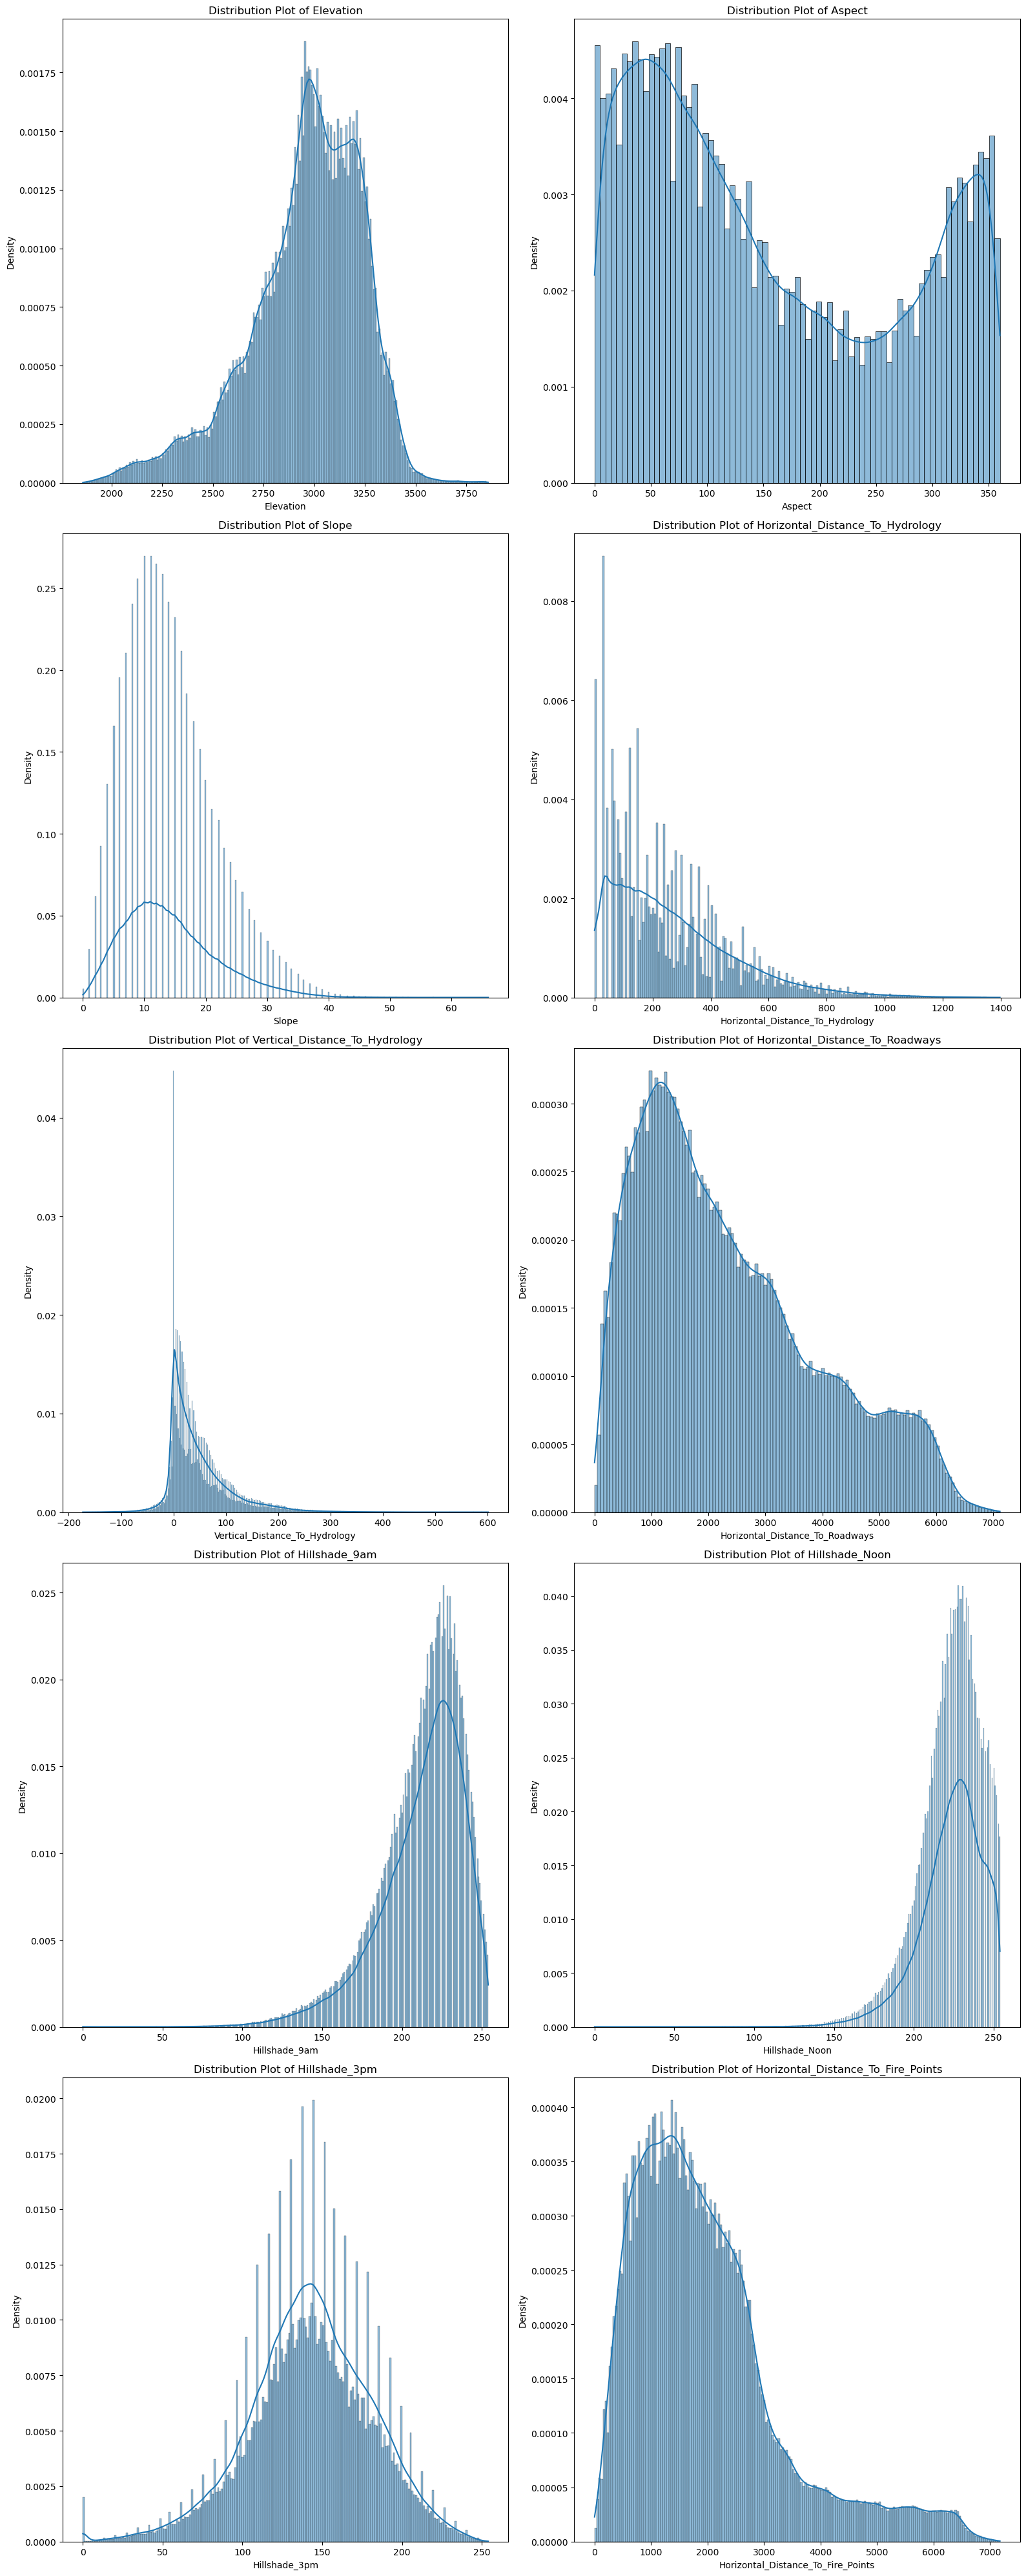

In [18]:
plot_numeric_columns_distributions(data=data, columns=numeric_columns, plots_in_row=2, plot_width=8)

Выбросов в числовых переменных не наблюдается, а значит для масштабирования применим `MinMaxScaler`, умещающий значения в диапазон от 0 до 1

Посмотрим на взаимную корреляцию числовых переменных и целевой

In [19]:
correlations = data[['Cover_Type'] + numeric_columns].corr()
correlations

,Cover_Type,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
Cover_Type,1.000000,-0.269554,0.017080,0.148285,-0.020317,0.081664,-0.153450,-0.035415,-0.096426,-0.048290,-0.108936
Elevation,-0.269554,1.000000,0.015735,-0.242697,0.306229,0.093306,0.365559,0.112179,0.205887,0.059148,0.148022
Aspect,0.017080,0.015735,1.000000,0.078728,0.017376,0.070305,0.025121,-0.579273,0.336103,0.646944,-0.109172
Slope,0.148285,-0.242697,0.078728,1.000000,-0.010607,0.274976,-0.215914,-0.327199,-0.526911,-0.175854,-0.185662
Horizontal_Distance_To_Hydrology,-0.020317,0.306229,0.017376,-0.010607,1.000000,0.606236,0.072030,-0.027088,0.046790,0.052330,0.051874
Vertical_Distance_To_Hydrology,0.081664,0.093306,0.070305,0.274976,0.606236,1.000000,-0.046372,-0.166333,-0.110957,0.034902,-0.069913
Horizontal_Distance_To_Roadways,-0.153450,0.365559,0.025121,-0.215914,0.072030,-0.046372,1.000000,0.034349,0.189461,0.106119,0.331580
Hillshade_9am,-0.035415,0.112179,-0.579273,-0.327199,-0.027088,-0.166333,0.034349,1.000000,0.010037,-0.780296,0.132669
Hillshade_Noon,-0.096426,0.205887,0.336103,-0.526911,0.046790,-0.110957,0.189461,0.010037,1.000000,0.594274,0.057329
Hillshade_3pm,-0.048290,0.059148,0.646944,-0.175854,0.052330,0.034902,0.106119,-0.780296,0.594274,1.000000,-0.047981


И в виде тепловой карты

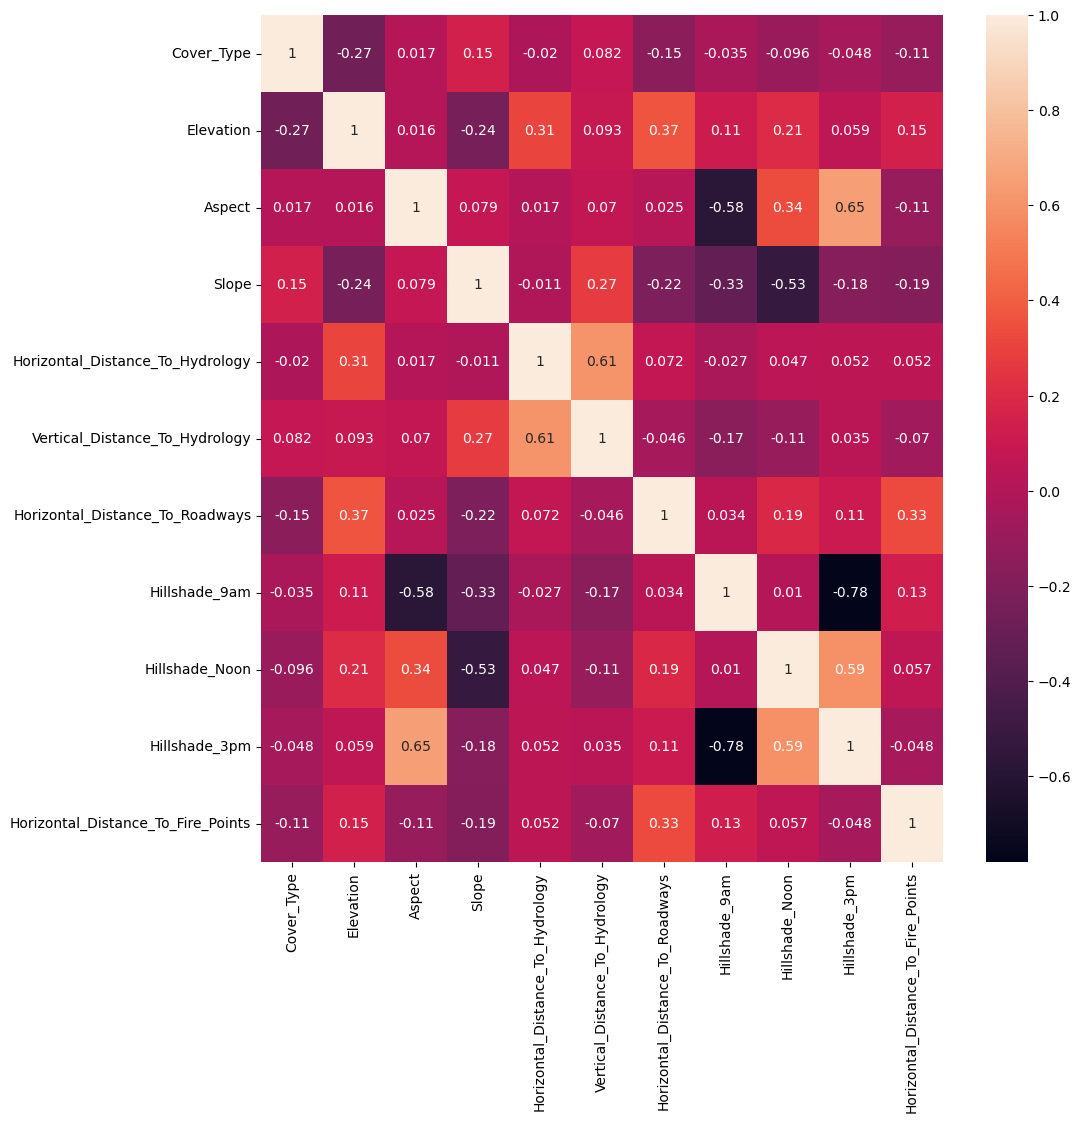

In [20]:
plt.subplots(figsize=(11, 11))
sns.heatmap(correlations, annot=True)
plt.show()

Сильных зависимостей (больше 0.8) не наблюдается, поэтому о мультиколлинеарности пока говорить не стоит и по умолчанию все числовые переменные будут использованы при построении классифицирующей модели

Выделим категориальные переменные

In [21]:
categories

['Wilderness_Area1',
 'Wilderness_Area2',
 'Wilderness_Area3',
 'Wilderness_Area4',
 'Soil_Type1',
 'Soil_Type2',
 'Soil_Type3',
 'Soil_Type4',
 'Soil_Type5',
 'Soil_Type6',
 'Soil_Type7',
 'Soil_Type8',
 'Soil_Type9',
 'Soil_Type10',
 'Soil_Type11',
 'Soil_Type12',
 'Soil_Type13',
 'Soil_Type14',
 'Soil_Type15',
 'Soil_Type16',
 'Soil_Type17',
 'Soil_Type18',
 'Soil_Type19',
 'Soil_Type20',
 'Soil_Type21',
 'Soil_Type22',
 'Soil_Type23',
 'Soil_Type24',
 'Soil_Type25',
 'Soil_Type26',
 'Soil_Type27',
 'Soil_Type28',
 'Soil_Type29',
 'Soil_Type30',
 'Soil_Type31',
 'Soil_Type32',
 'Soil_Type33',
 'Soil_Type34',
 'Soil_Type35',
 'Soil_Type36',
 'Soil_Type37',
 'Soil_Type38',
 'Soil_Type39',
 'Soil_Type40',
 'Cover_Type']

Построим их гистограммы

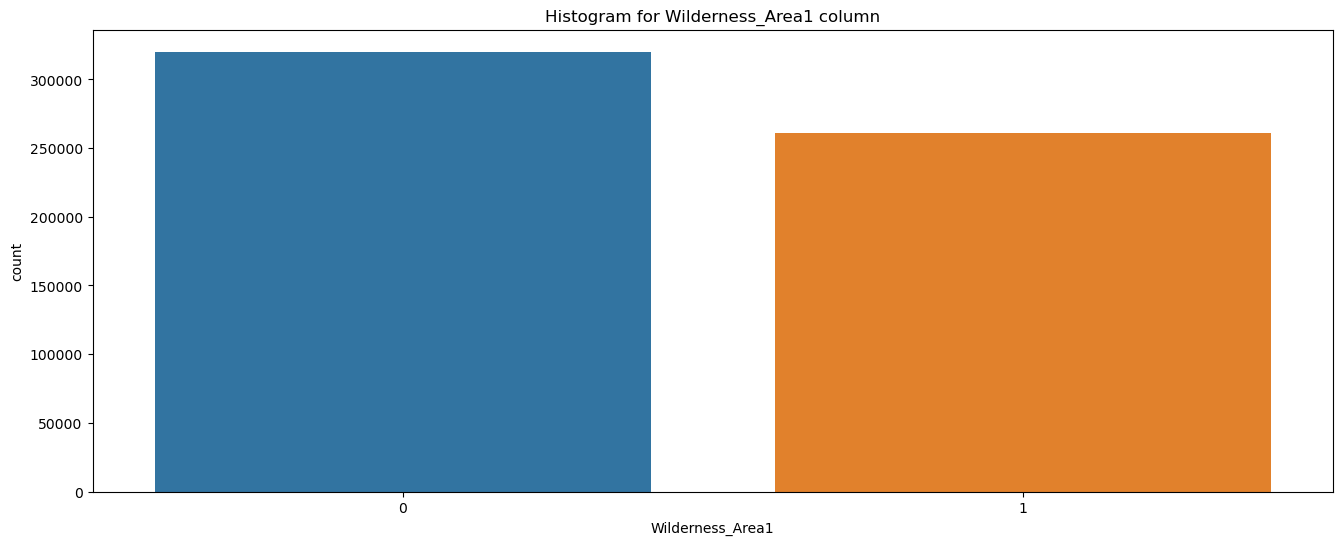

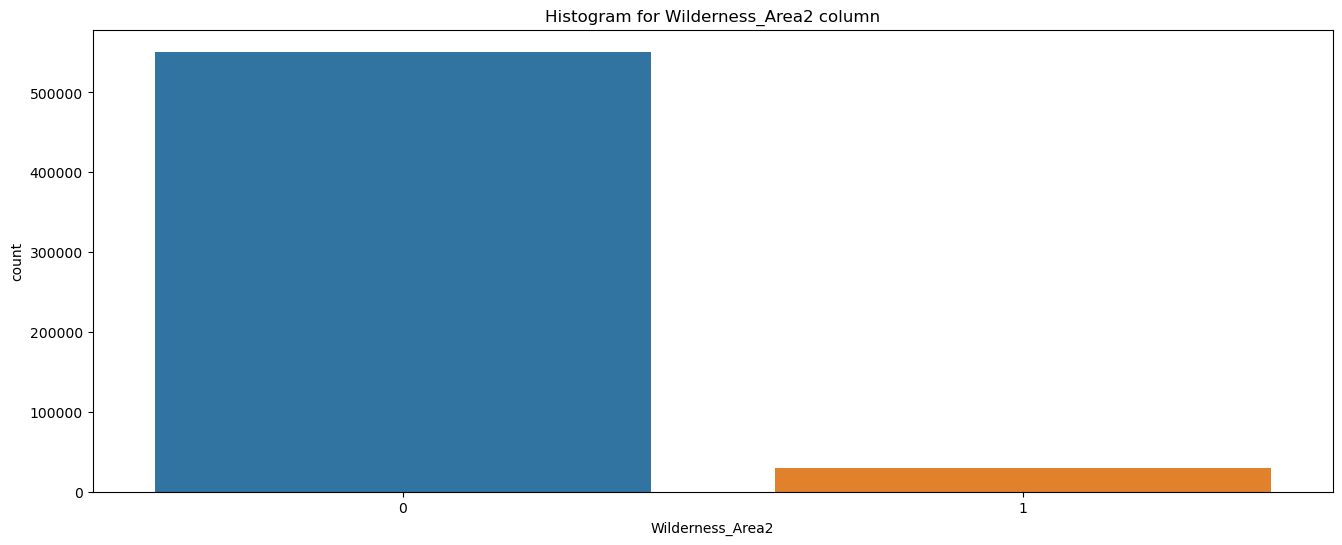

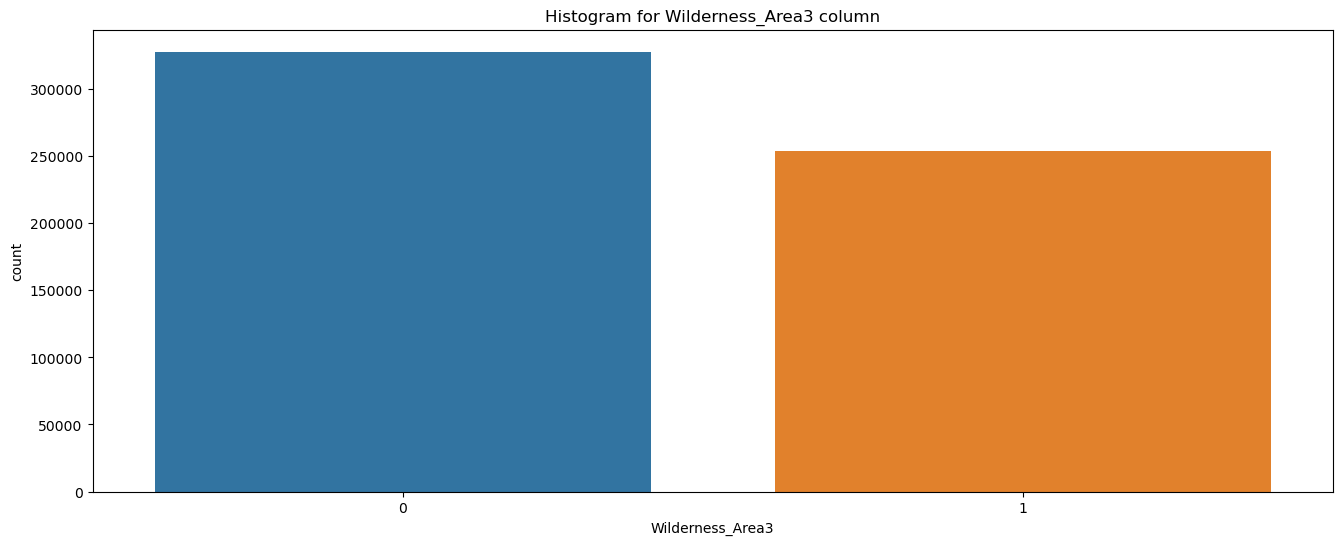

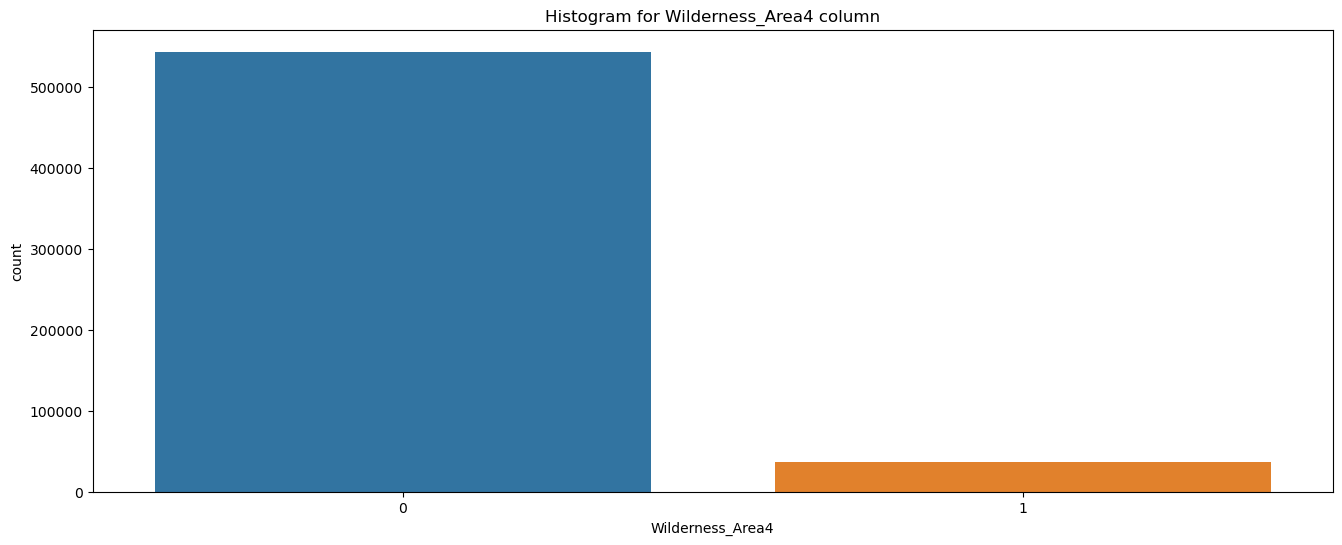

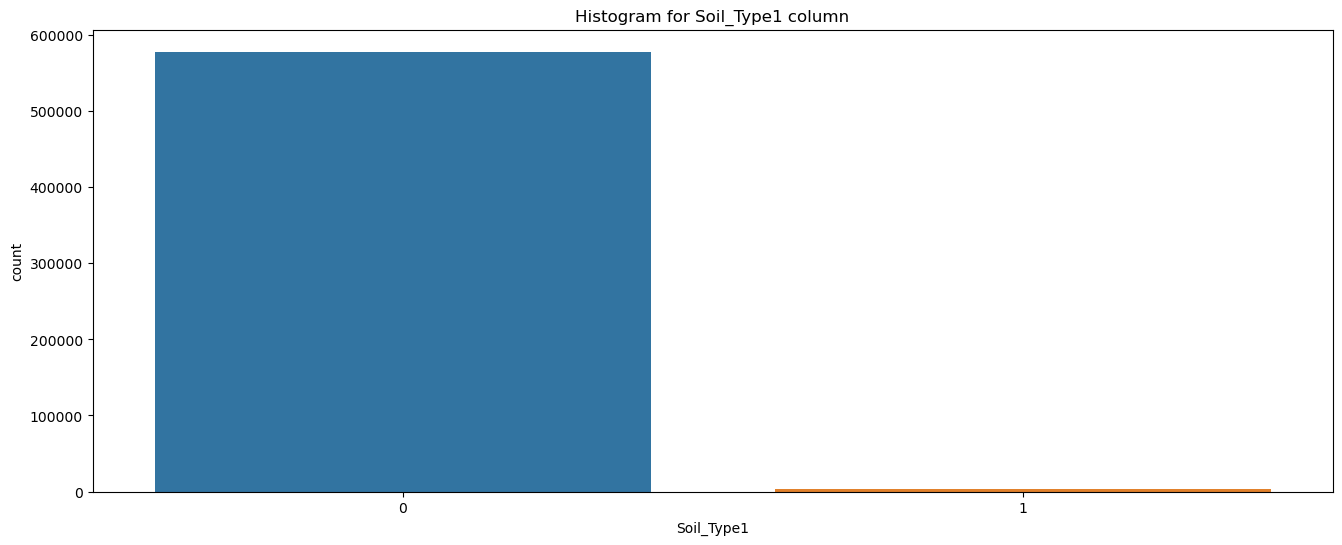

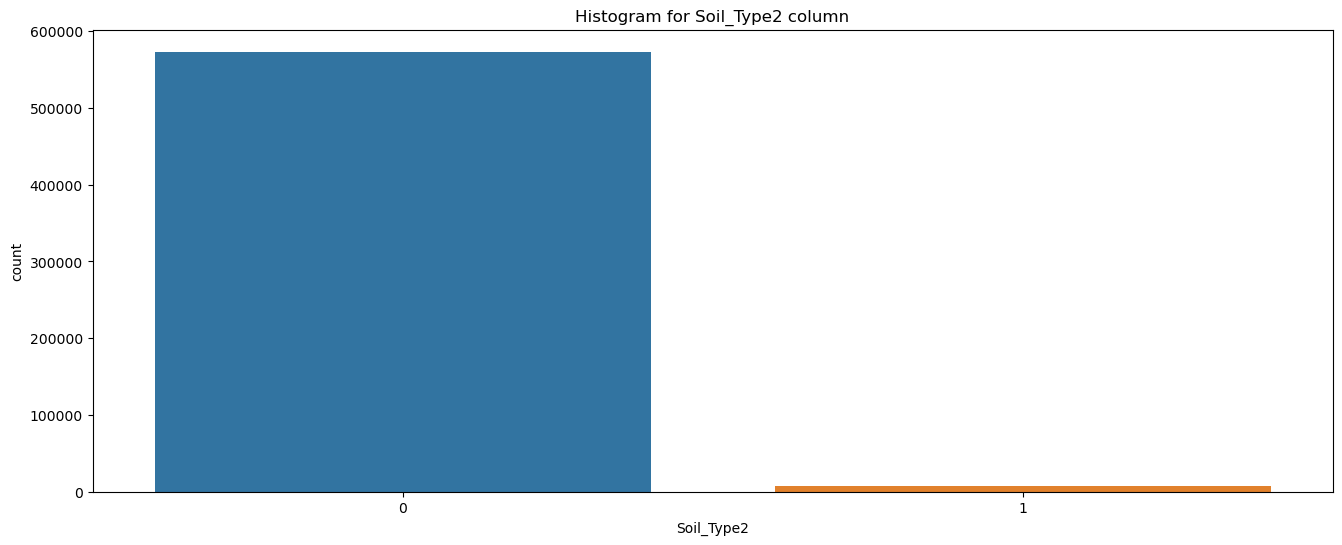

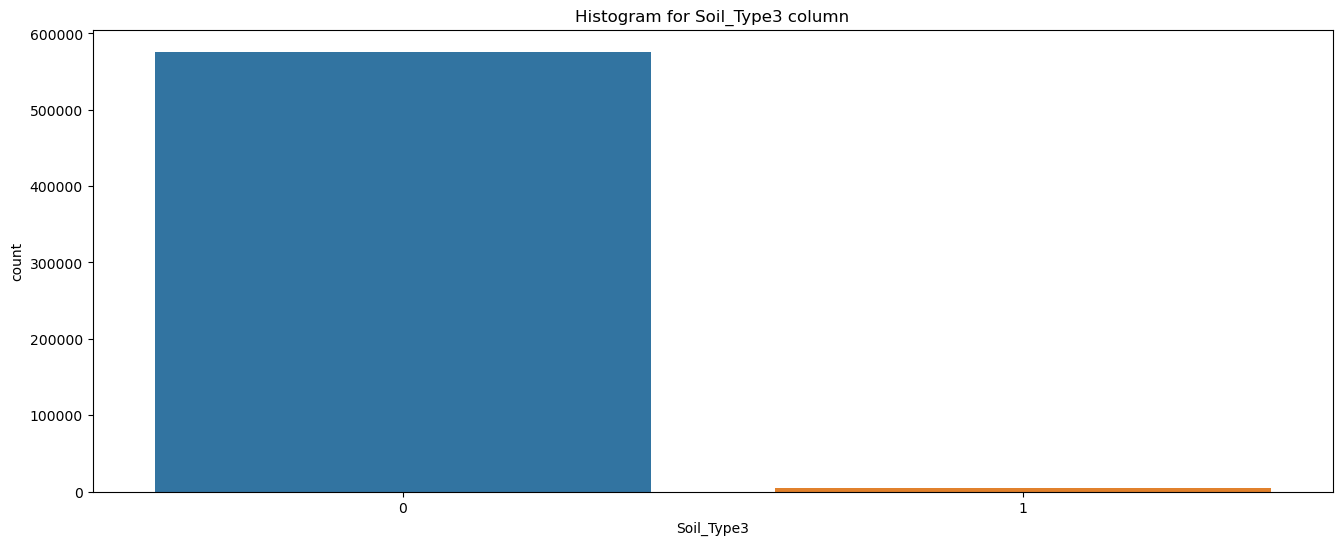

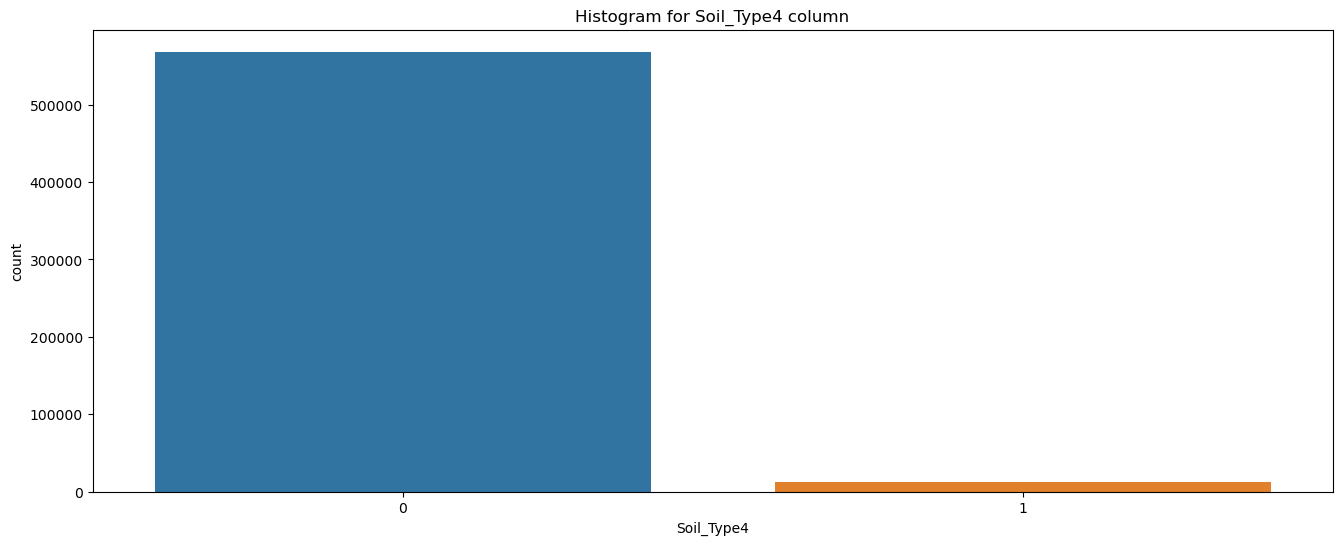

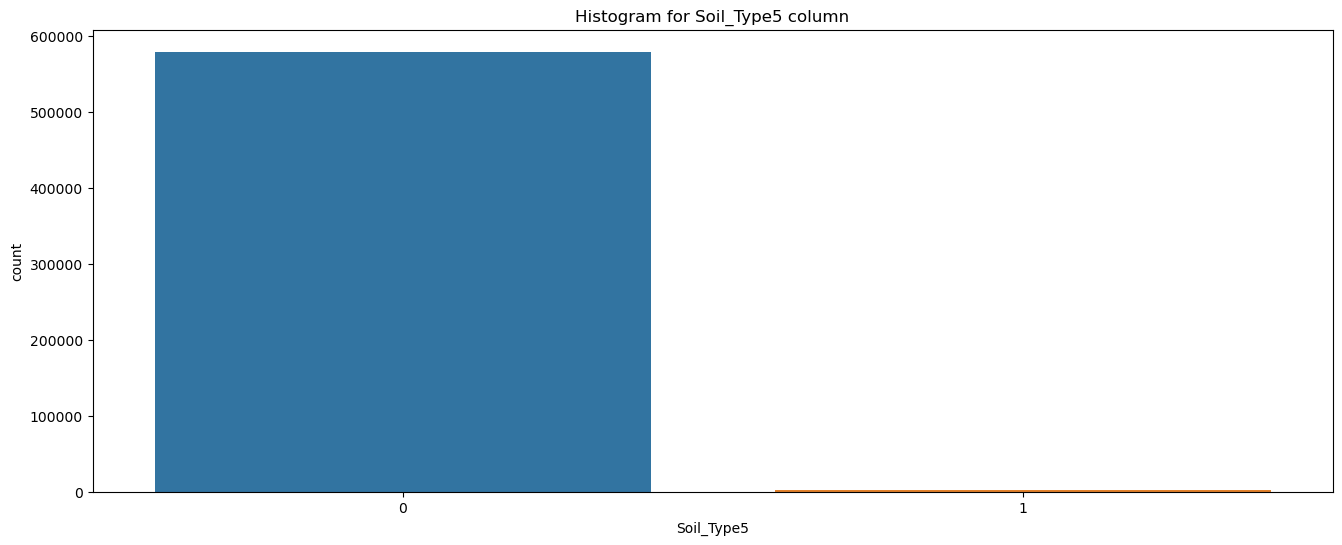

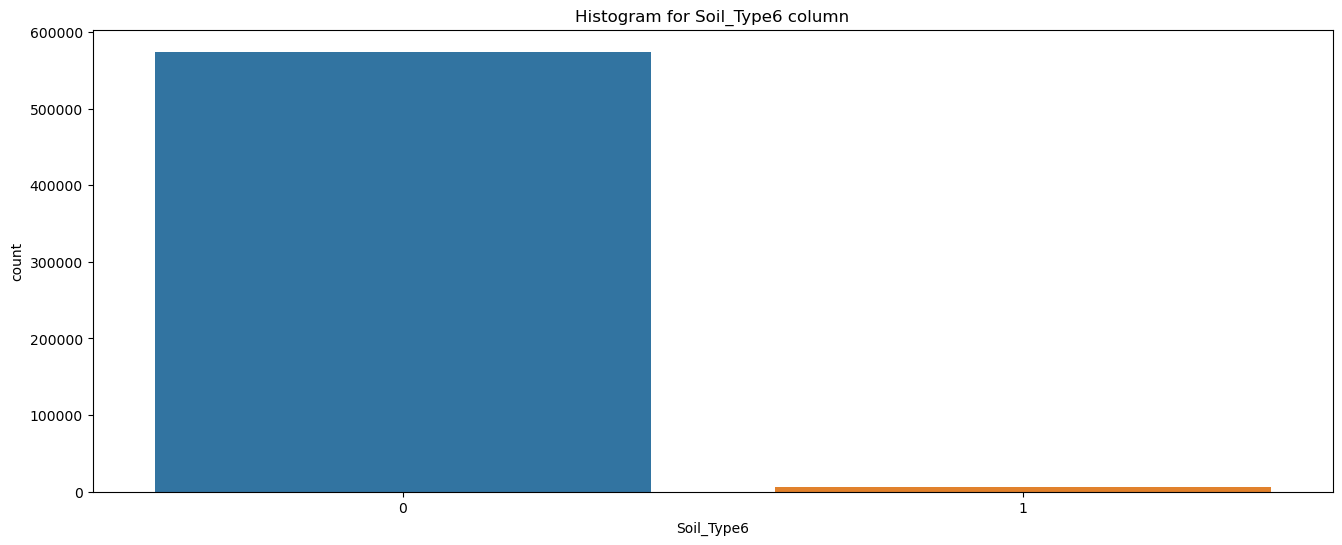

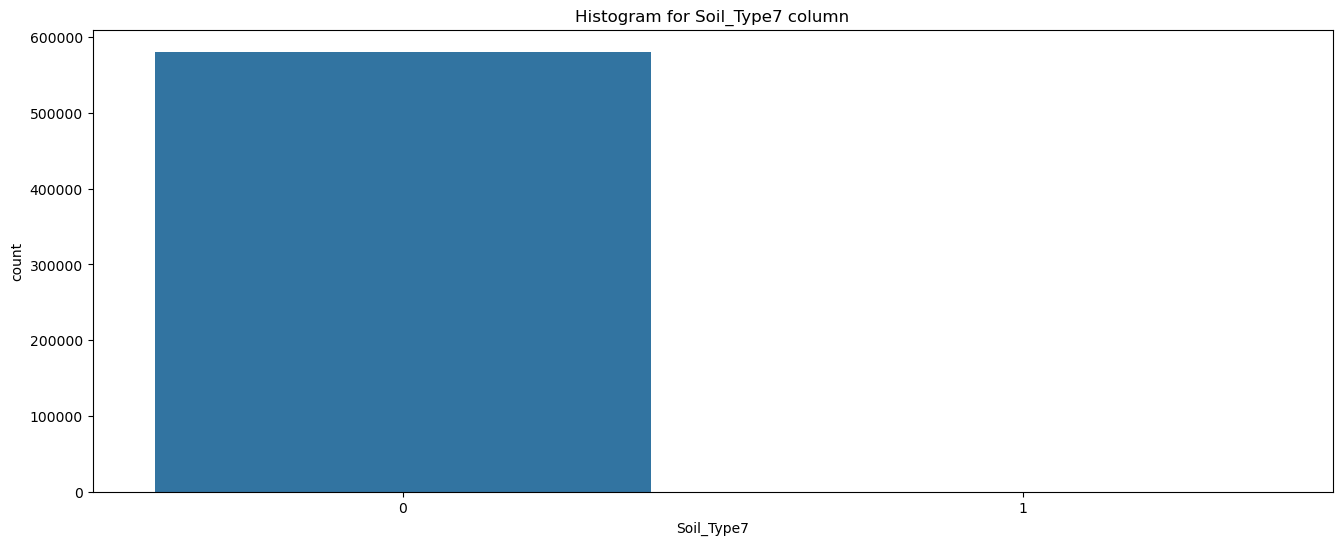

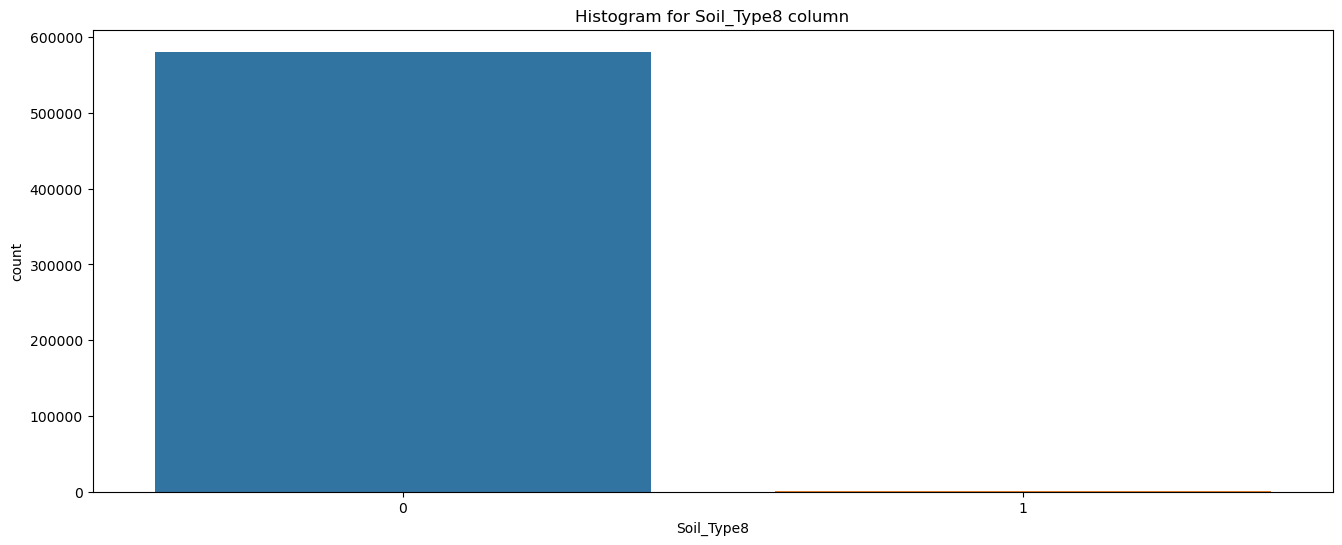

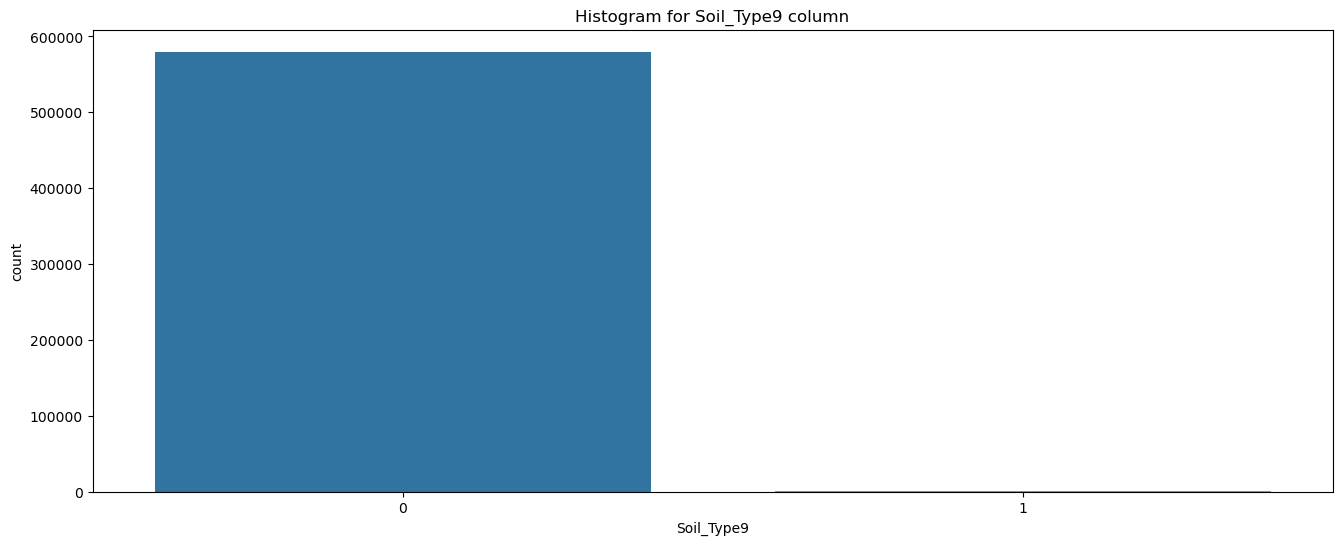

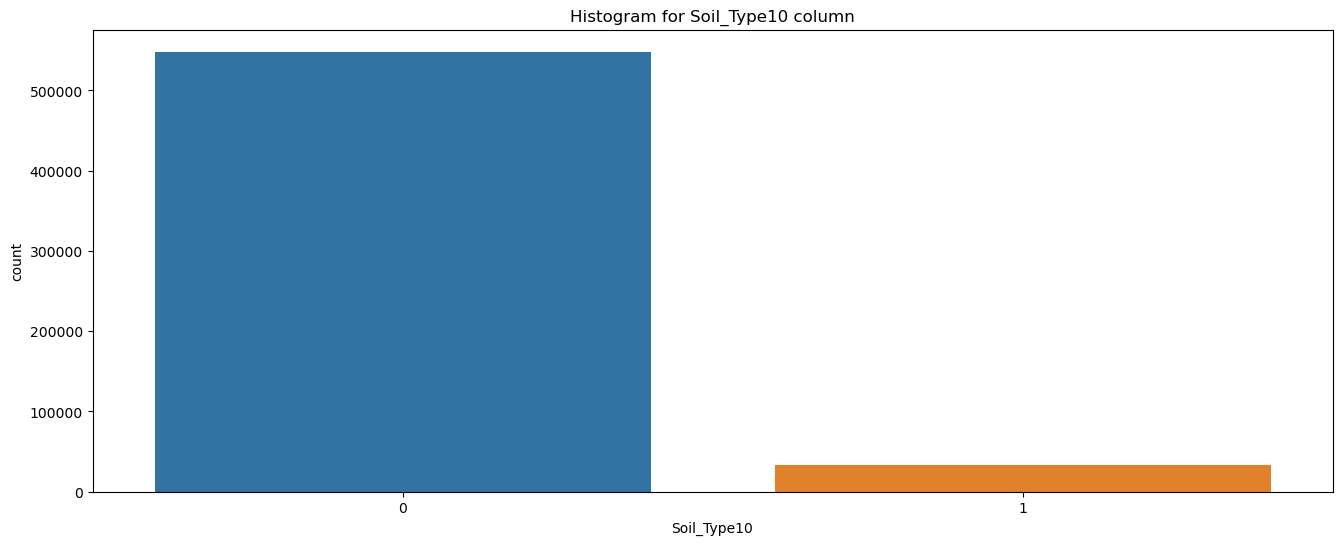

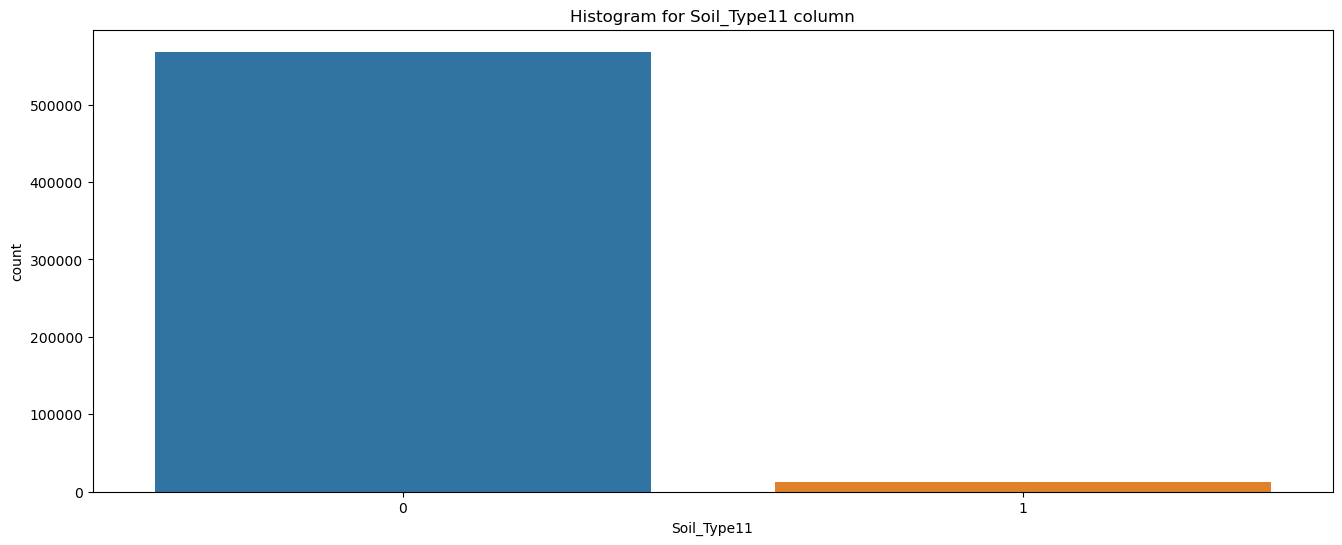

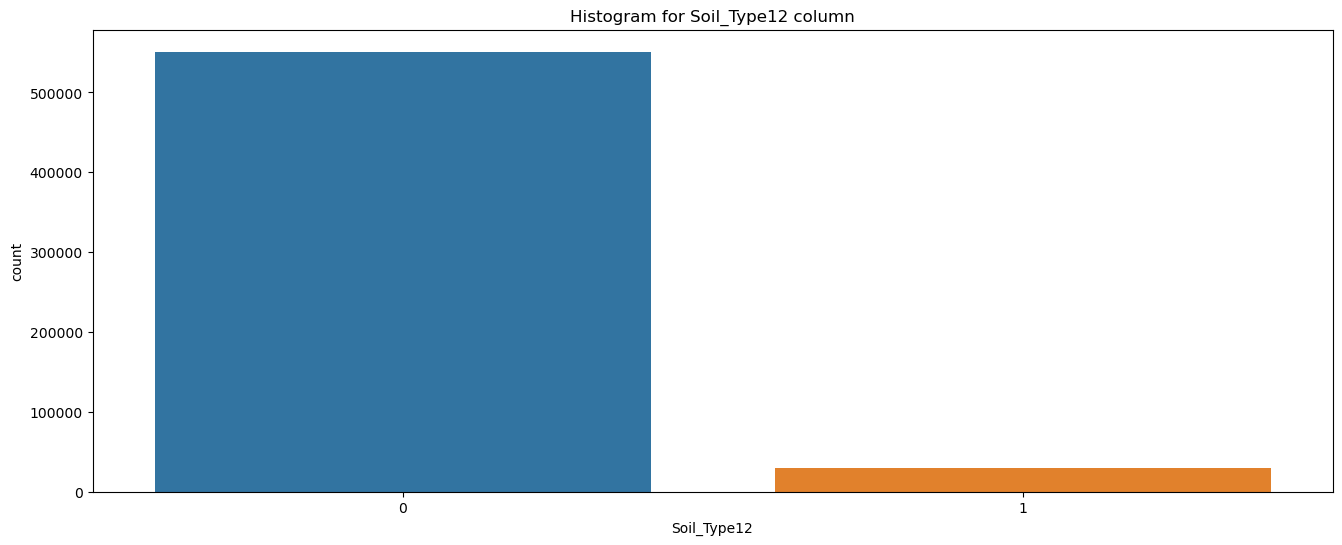

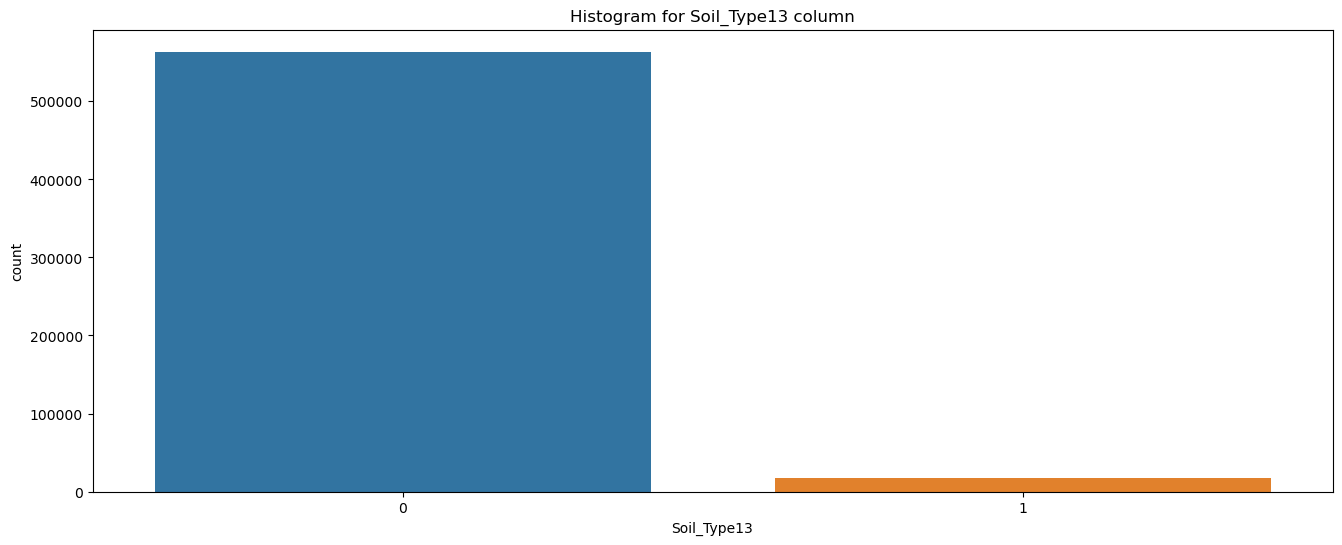

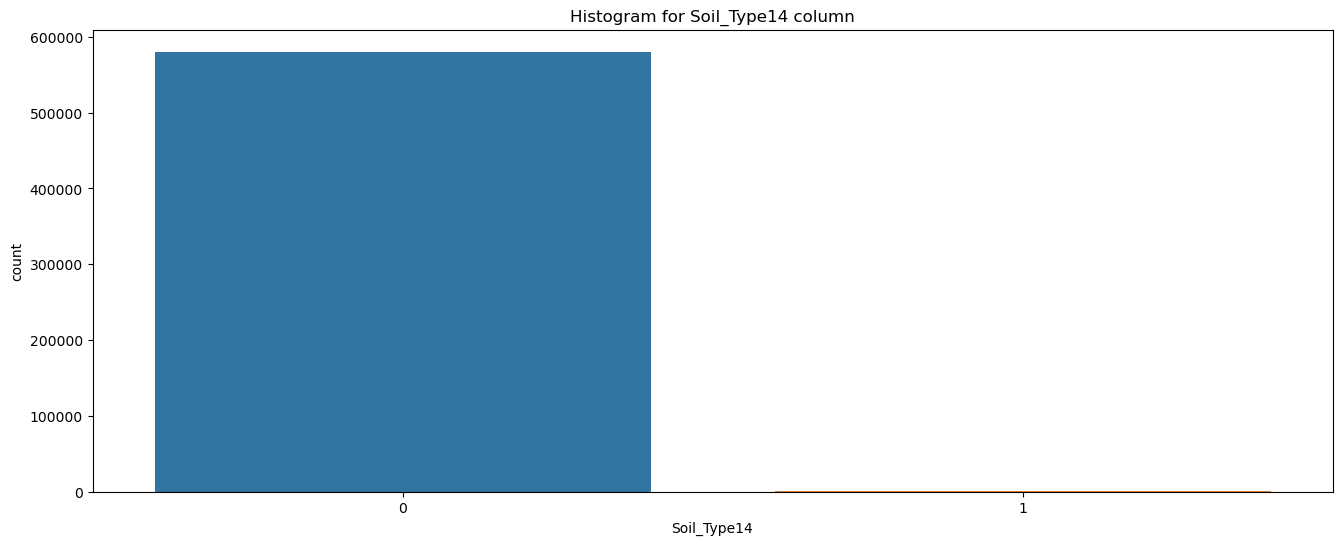

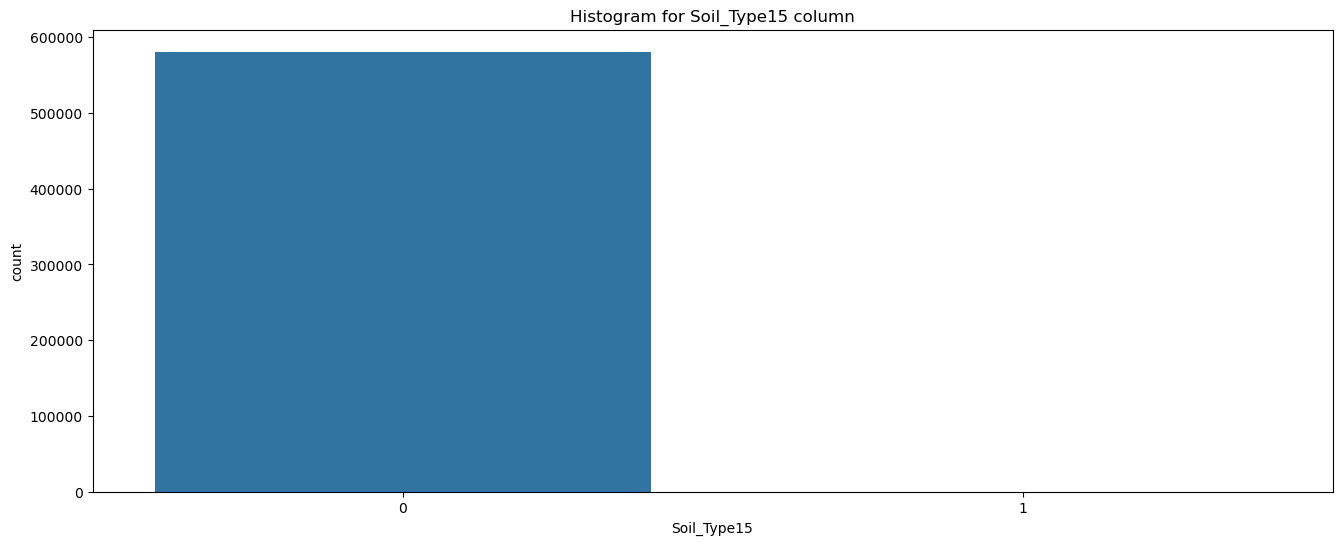

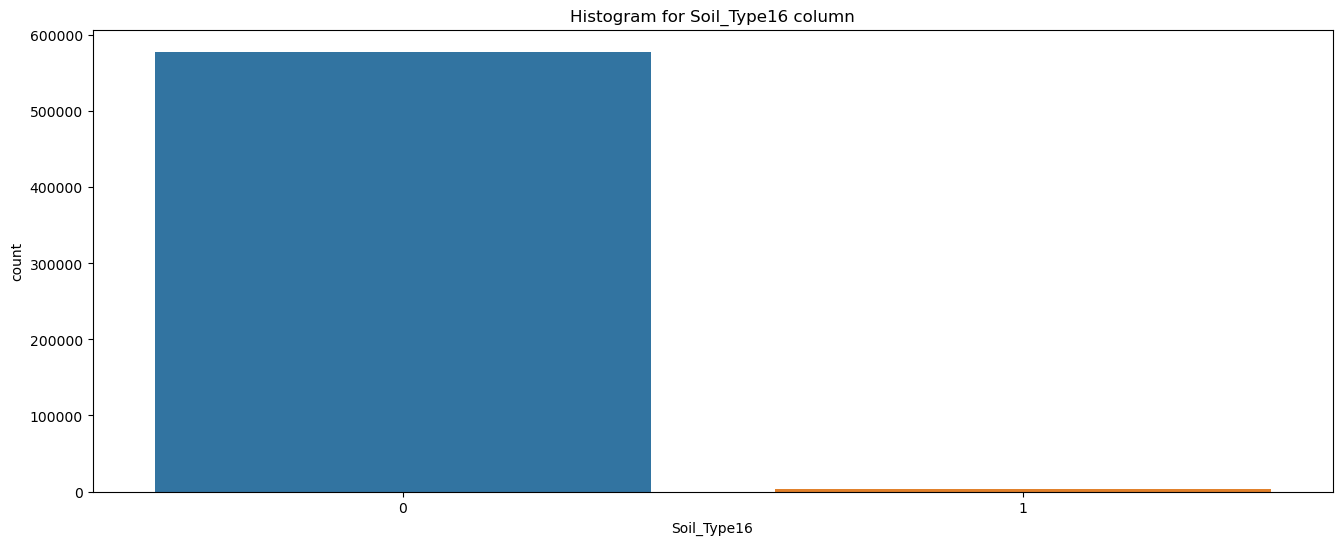

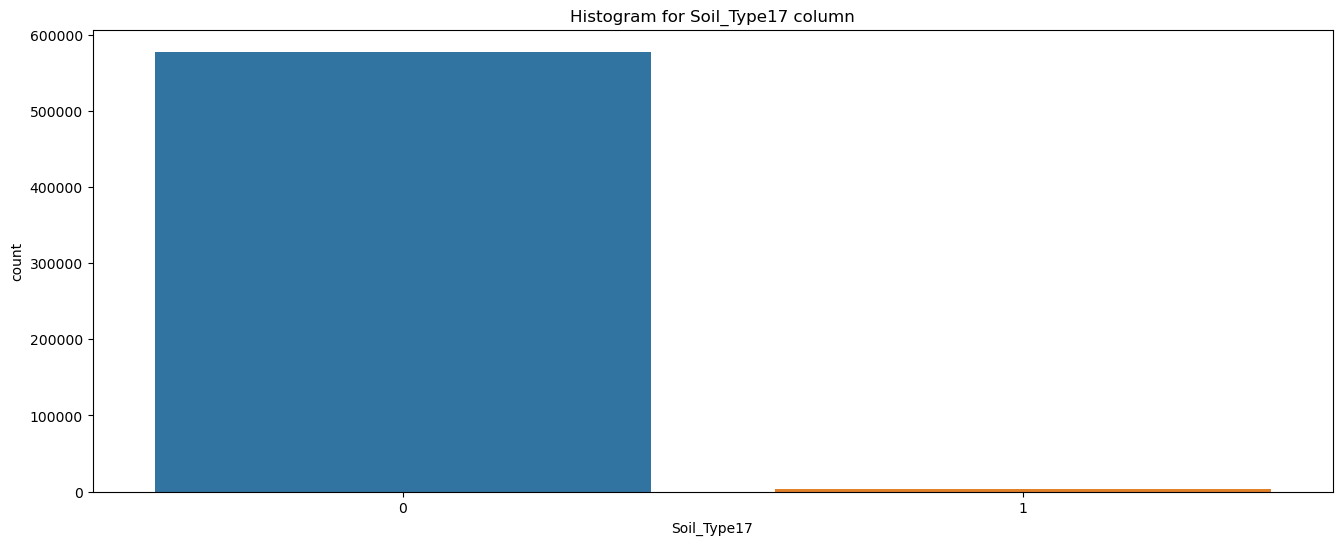

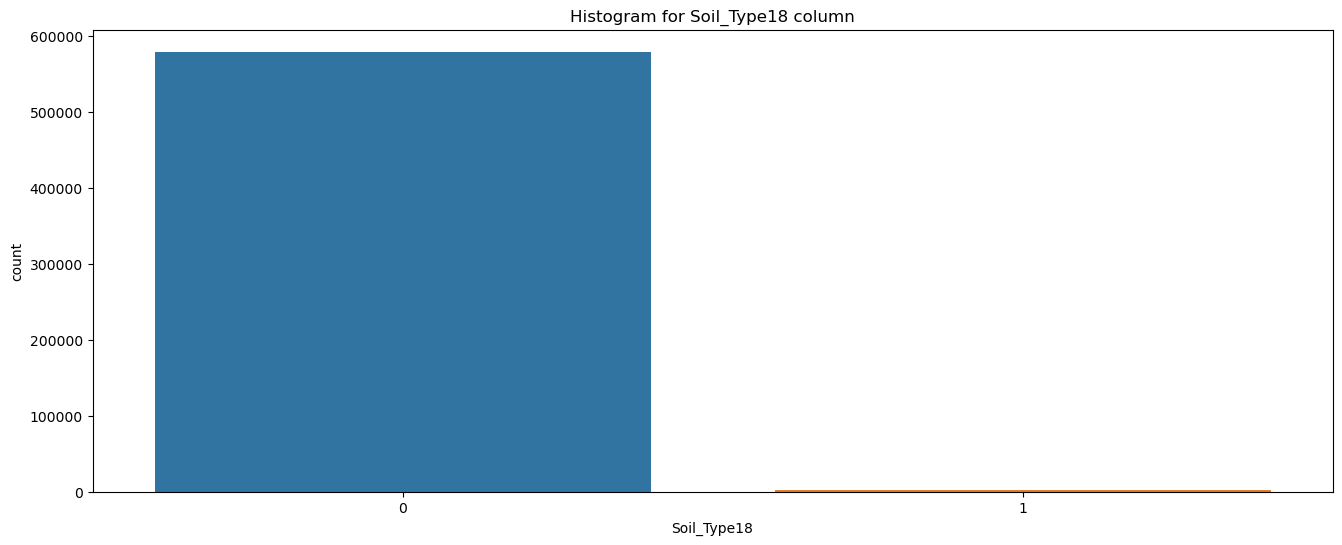

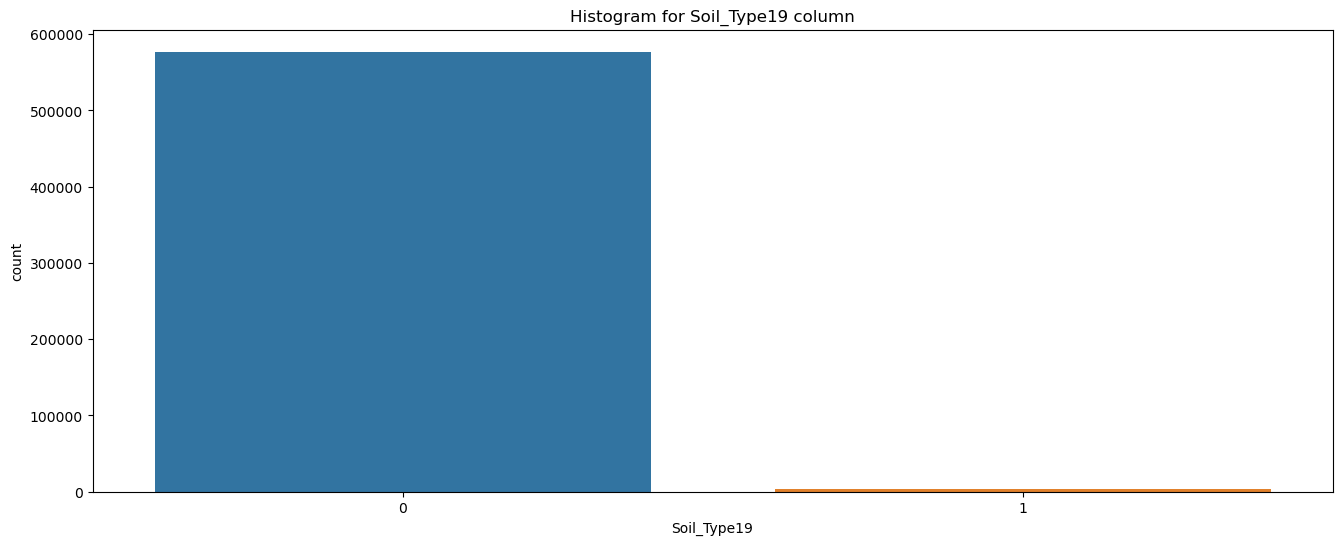

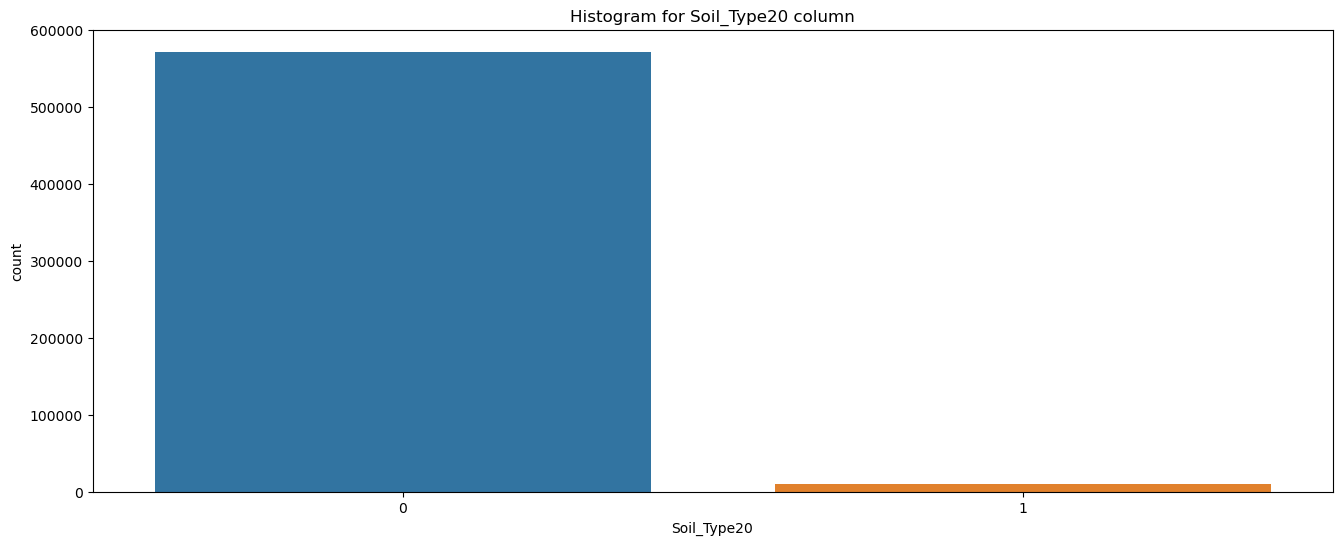

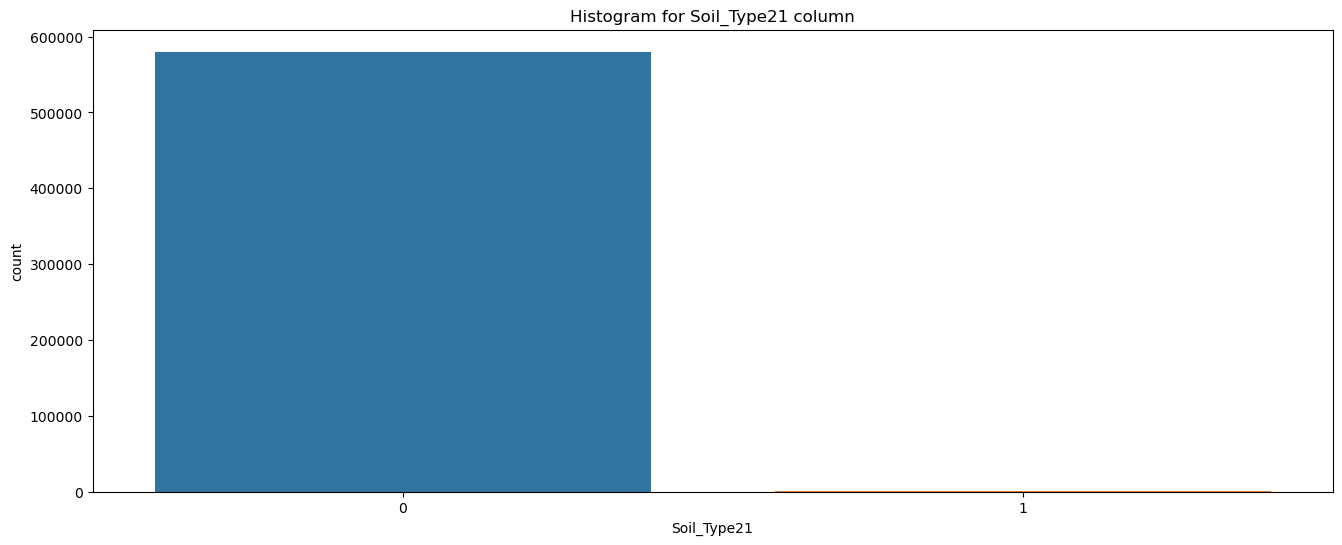

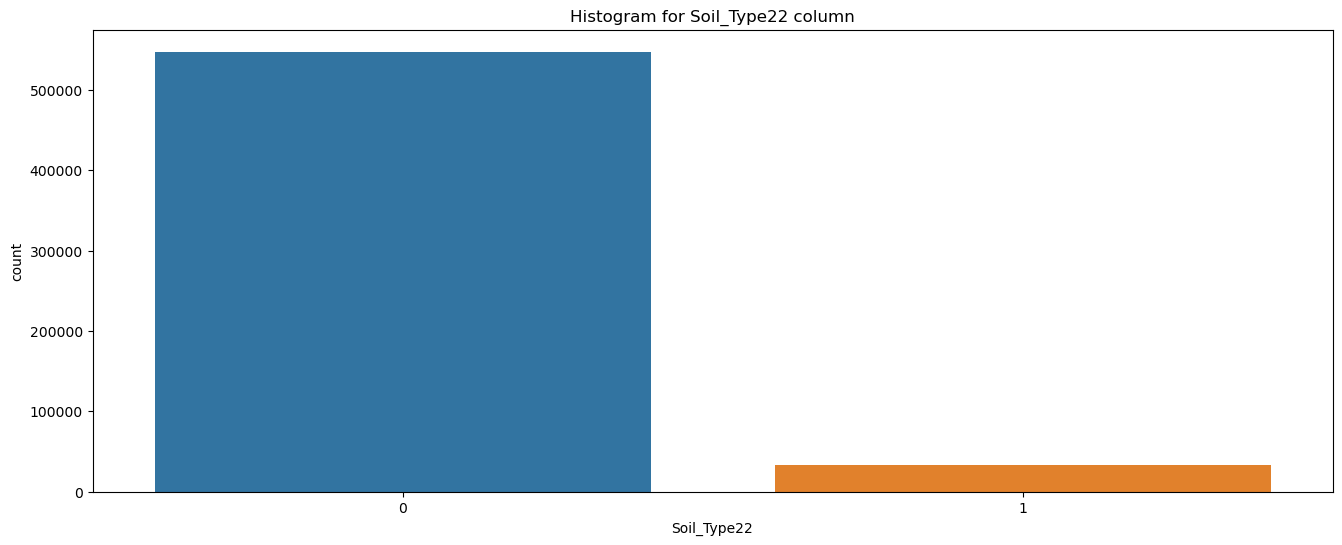

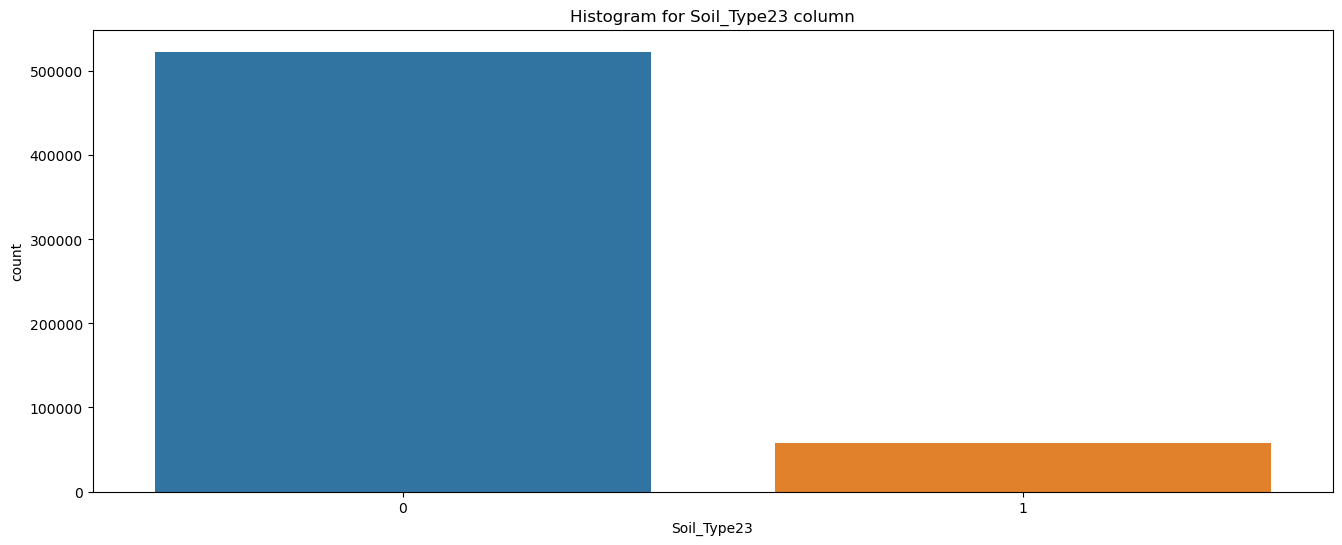

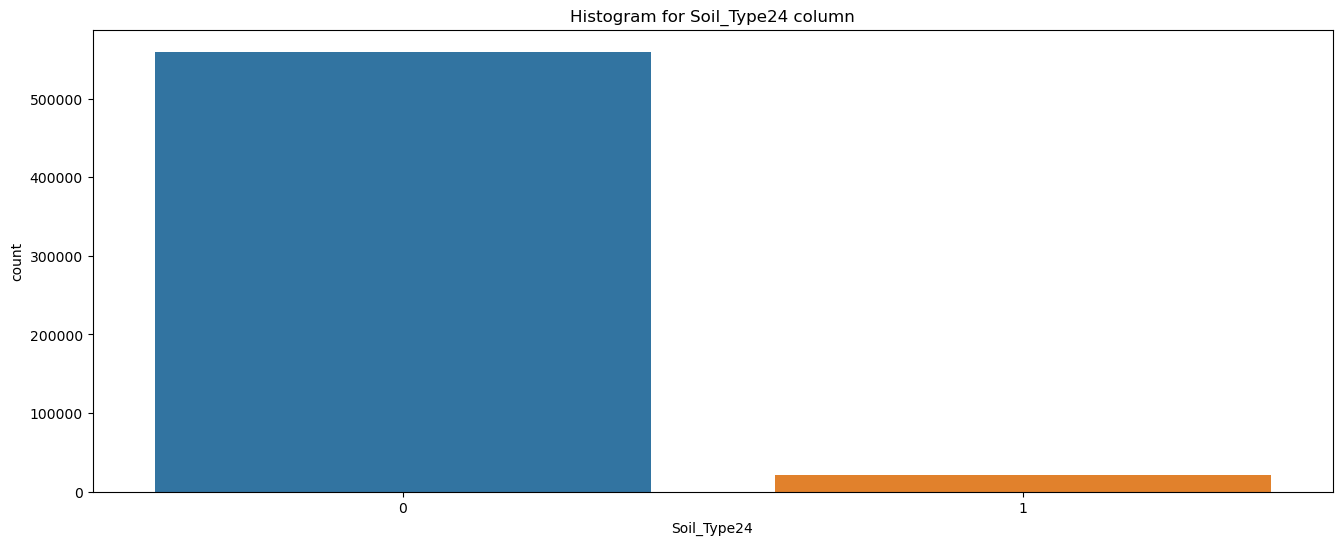

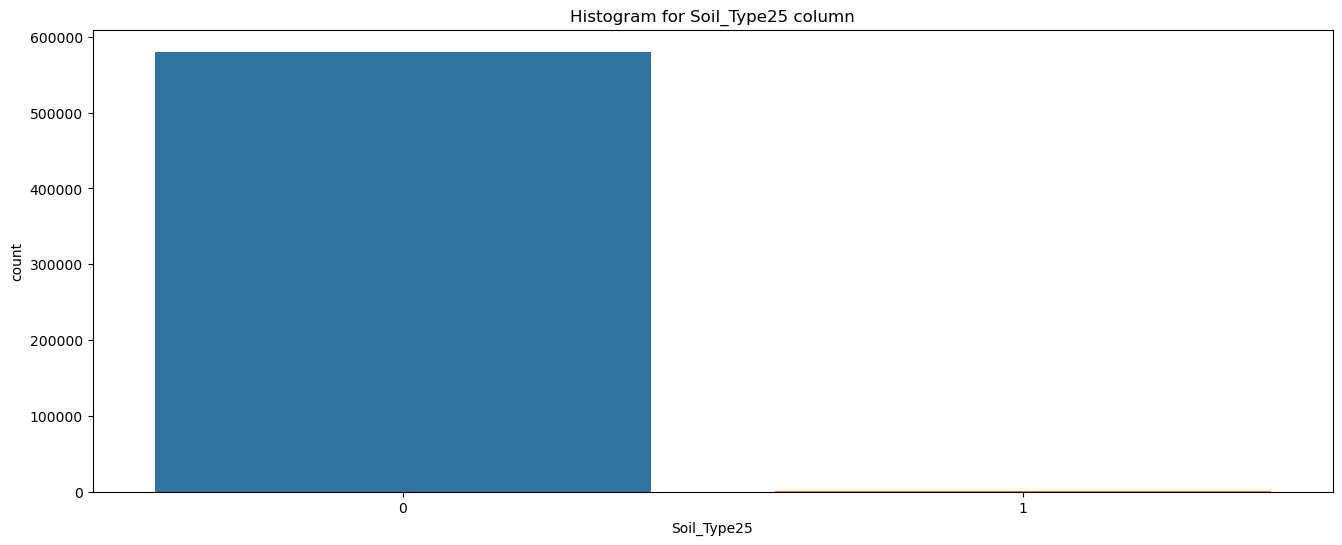

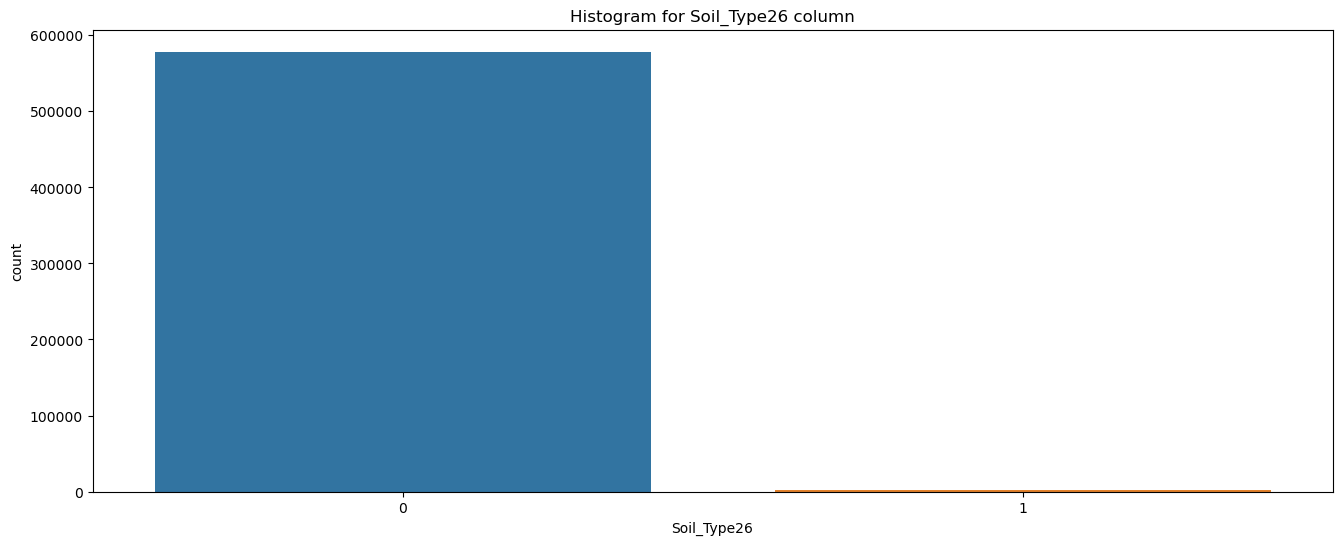

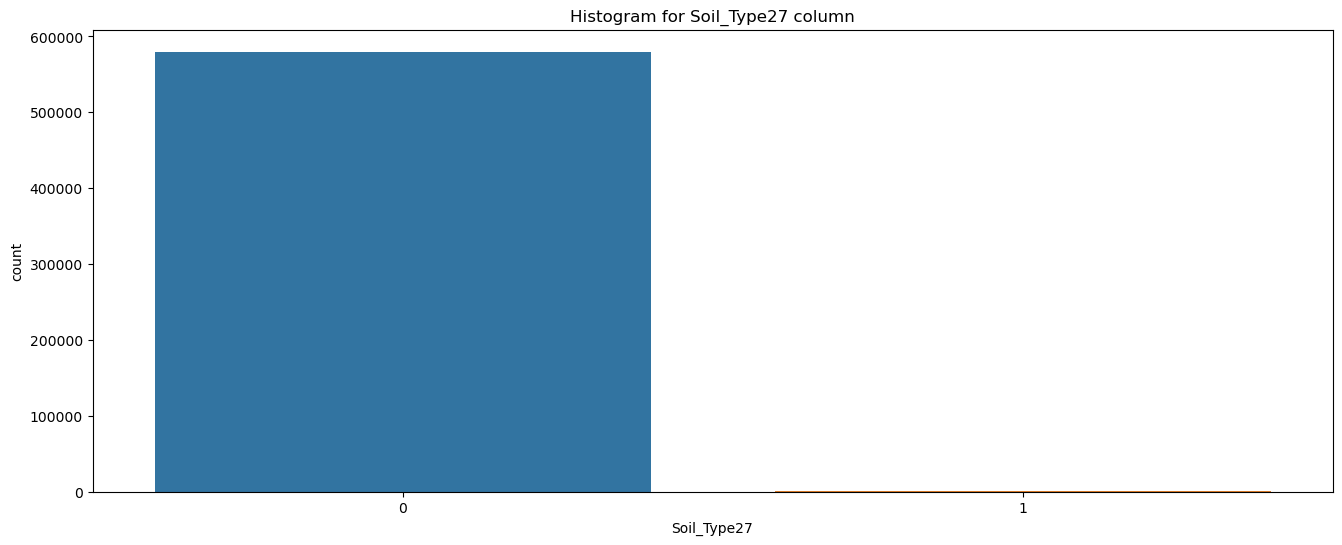

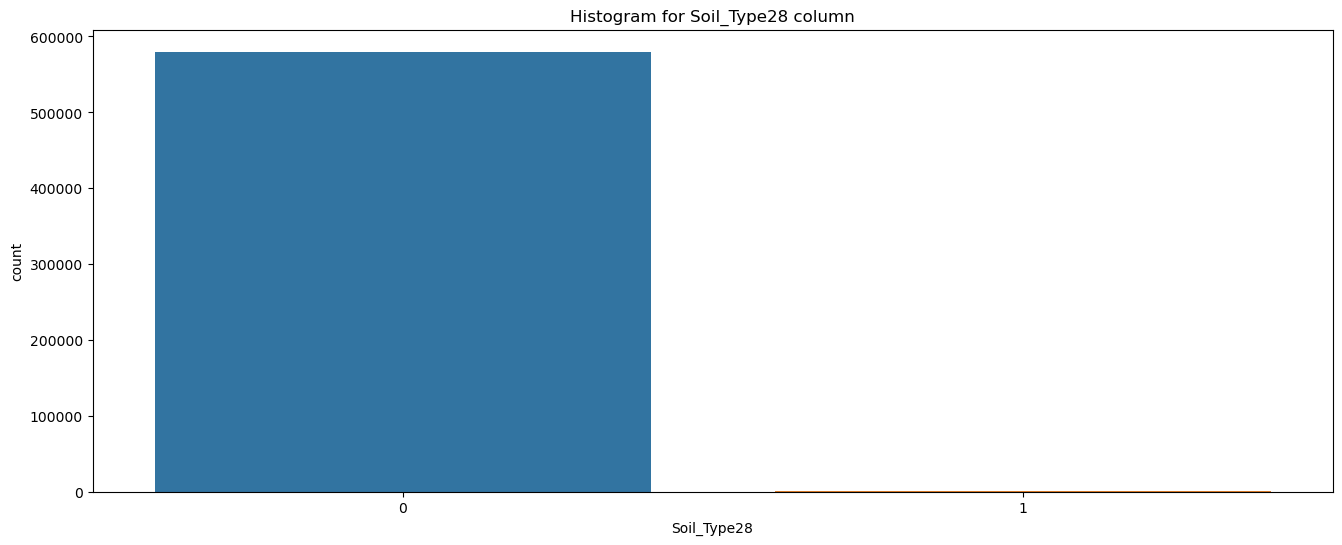

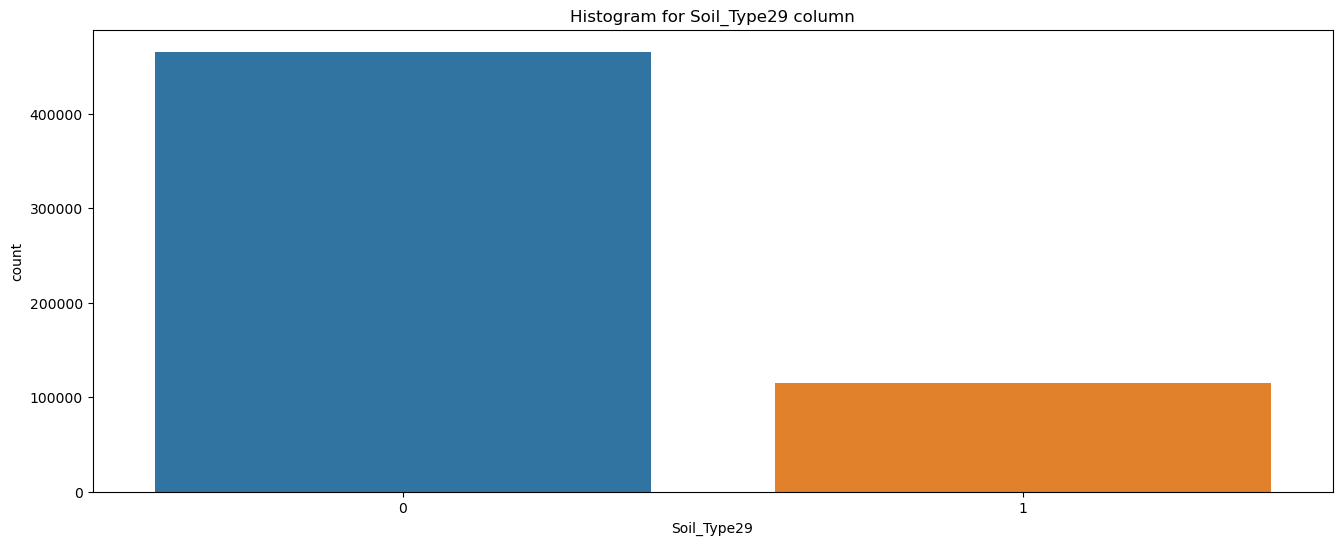

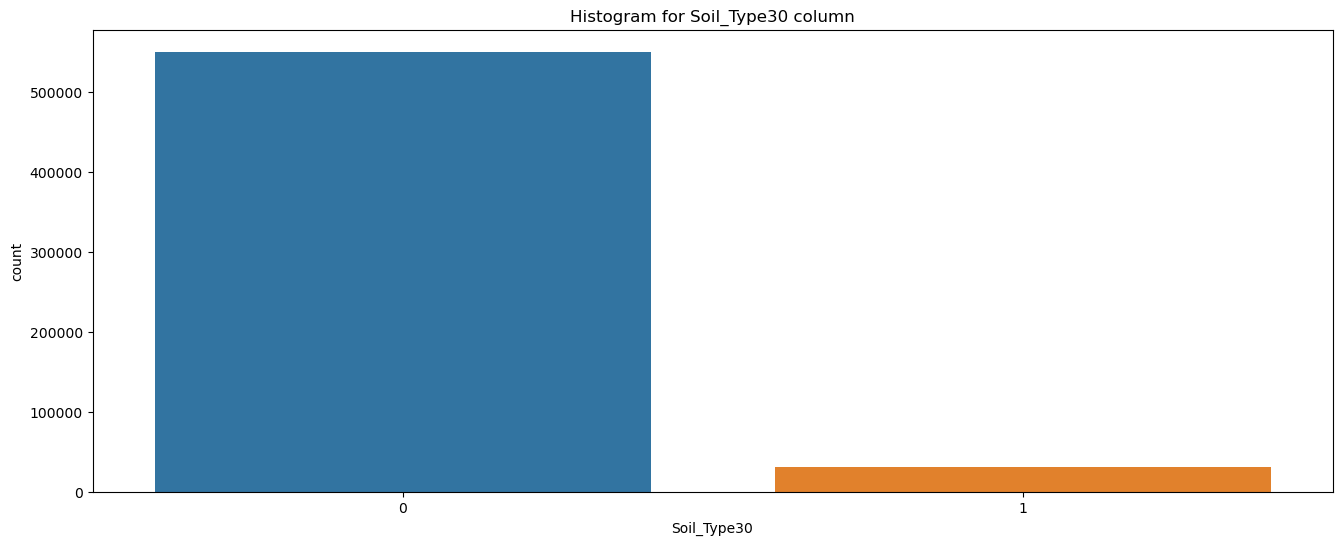

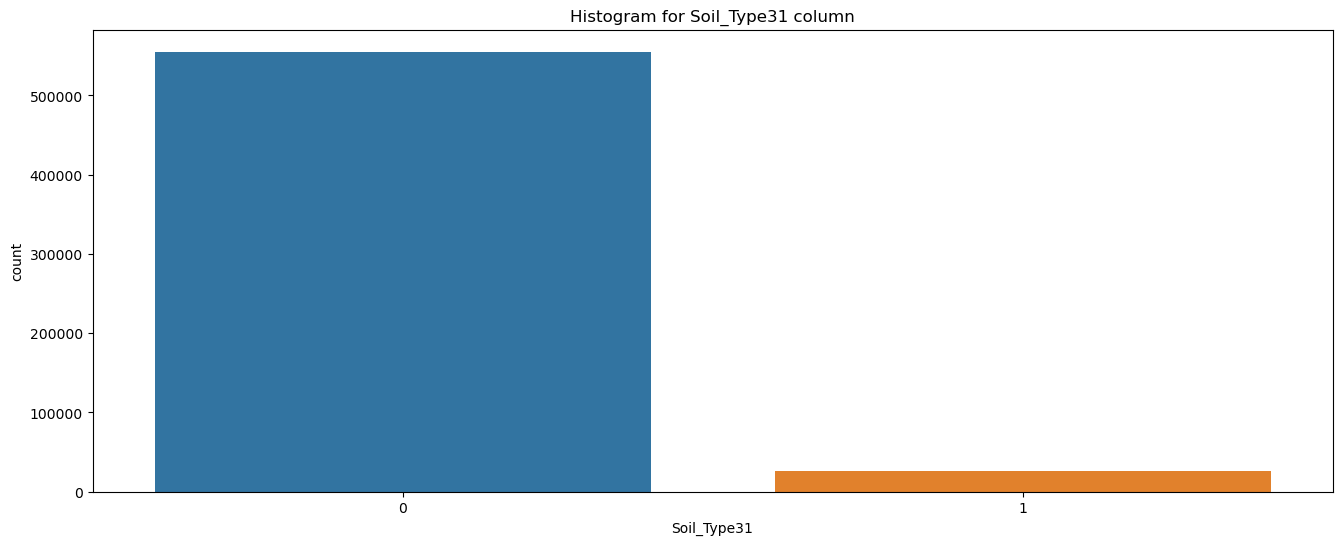

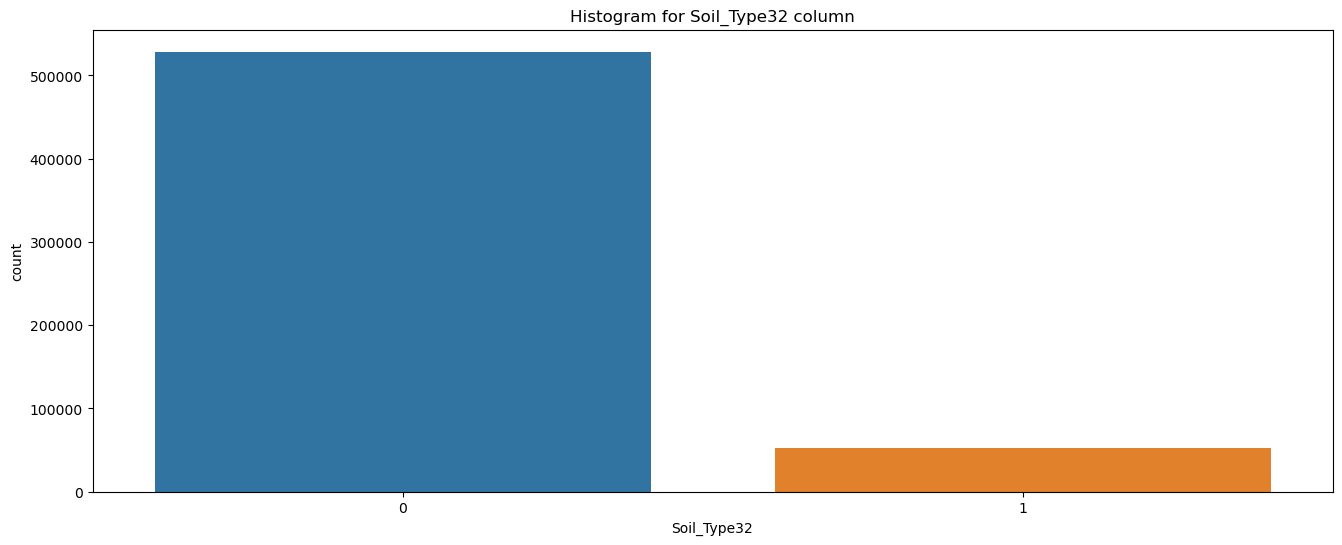

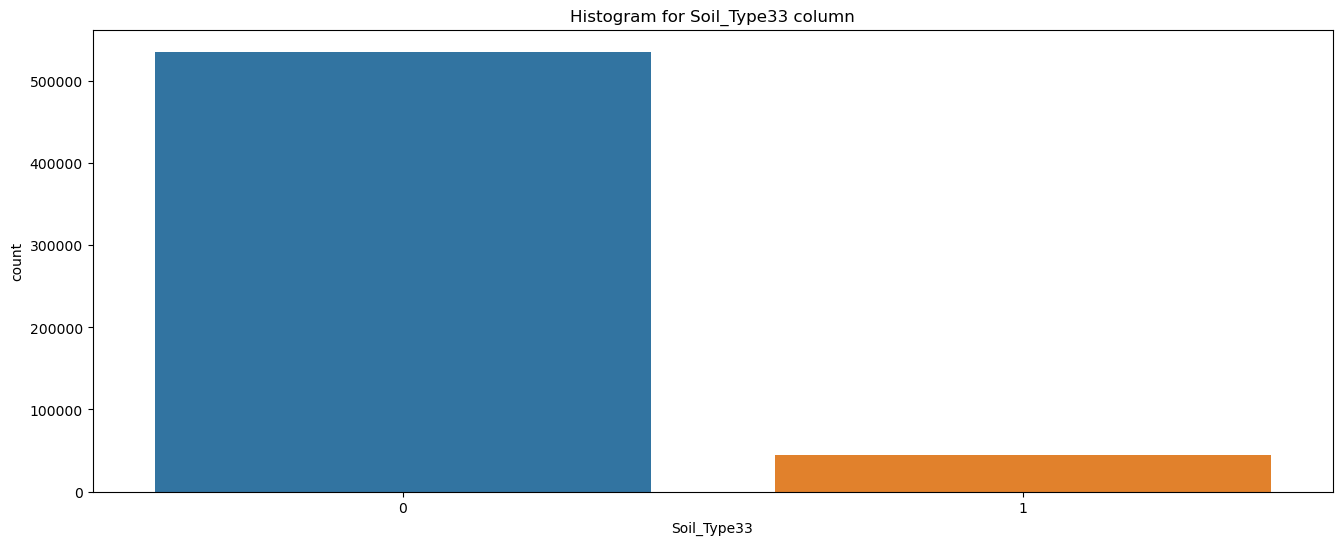

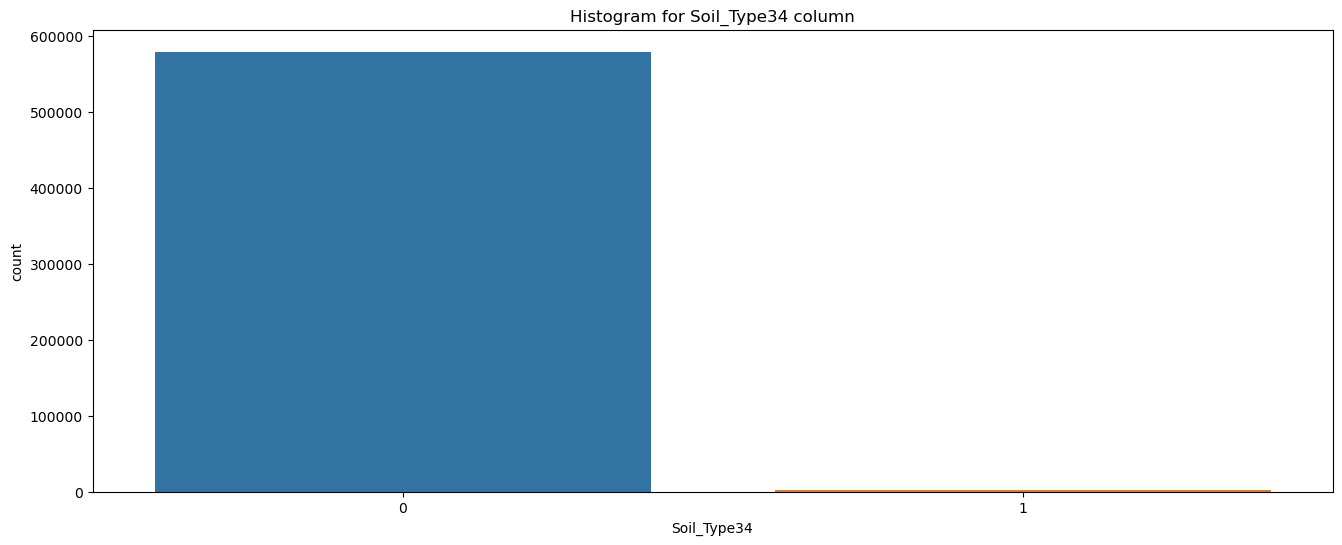

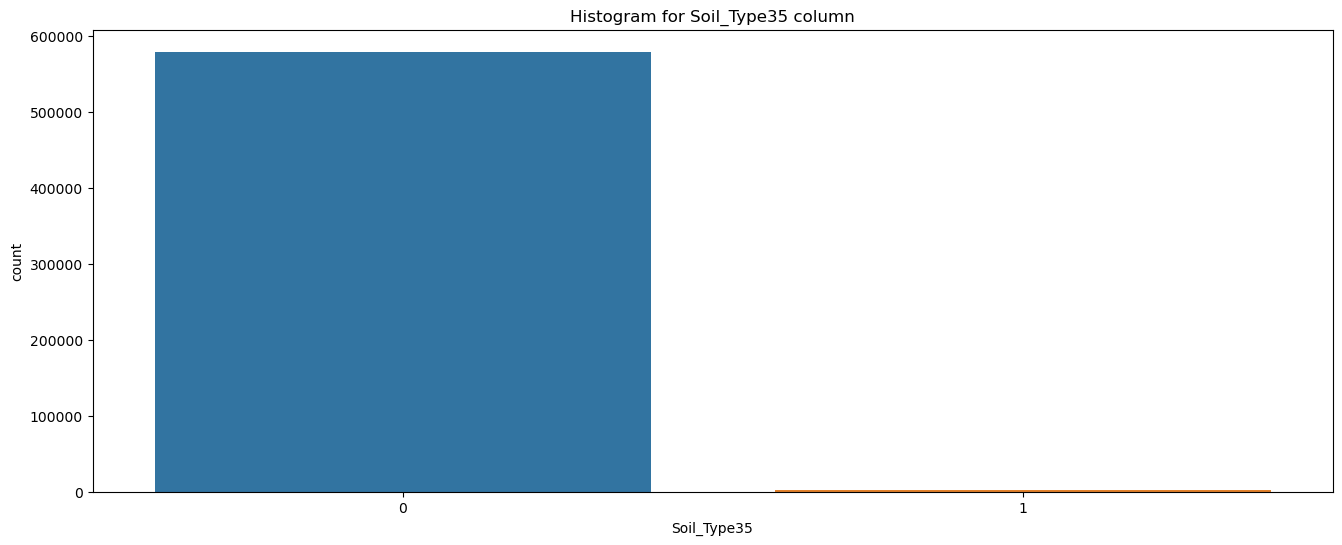

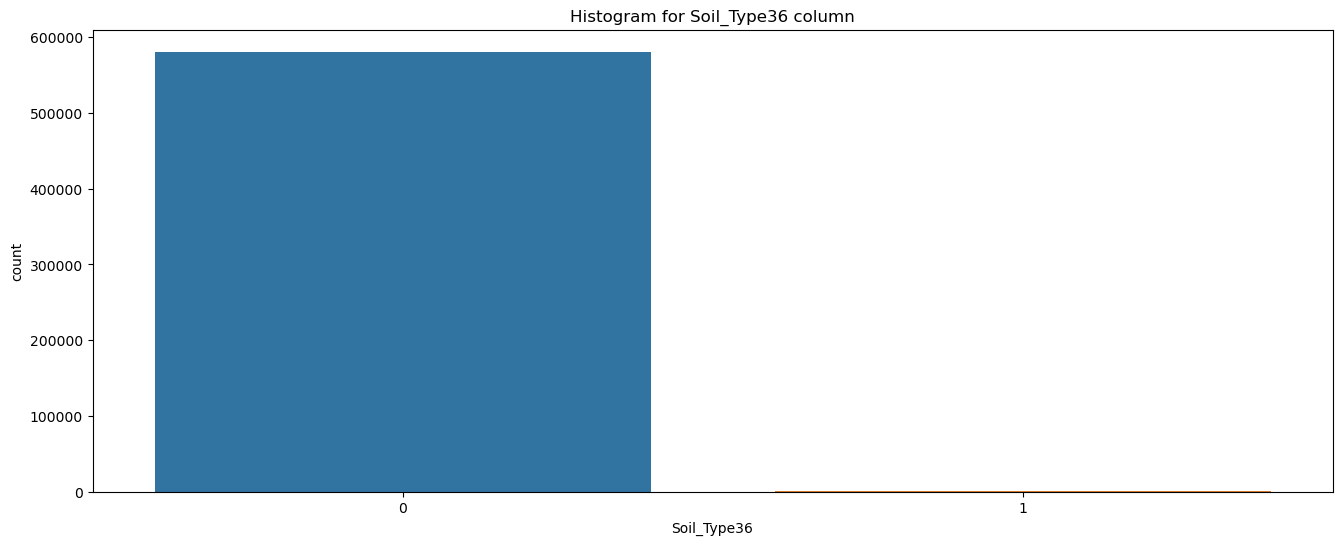

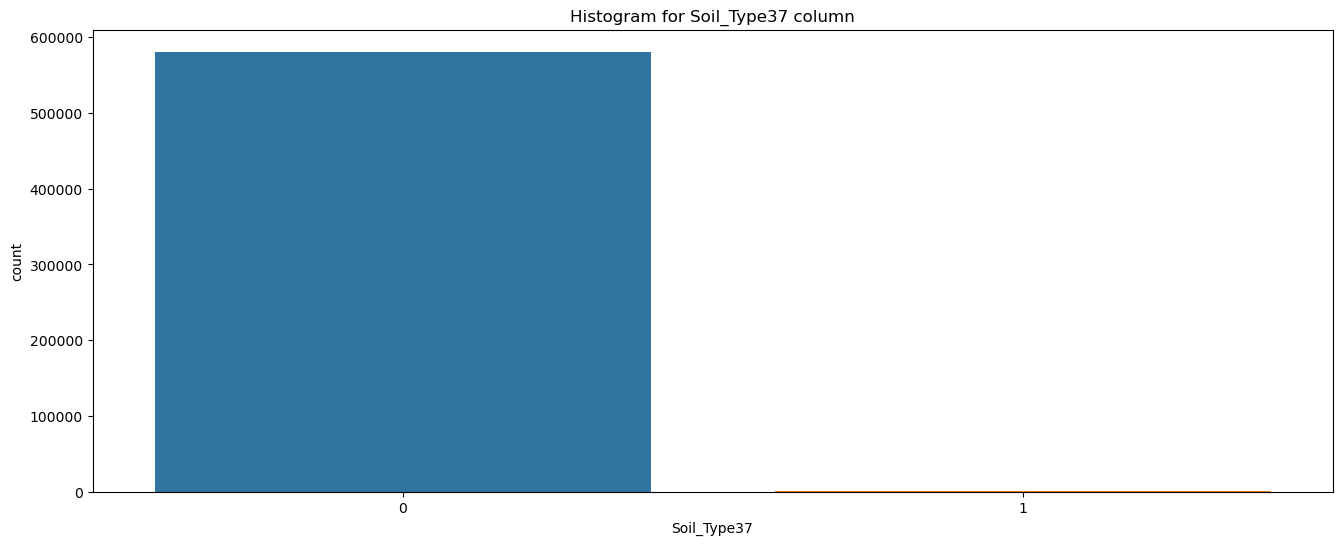

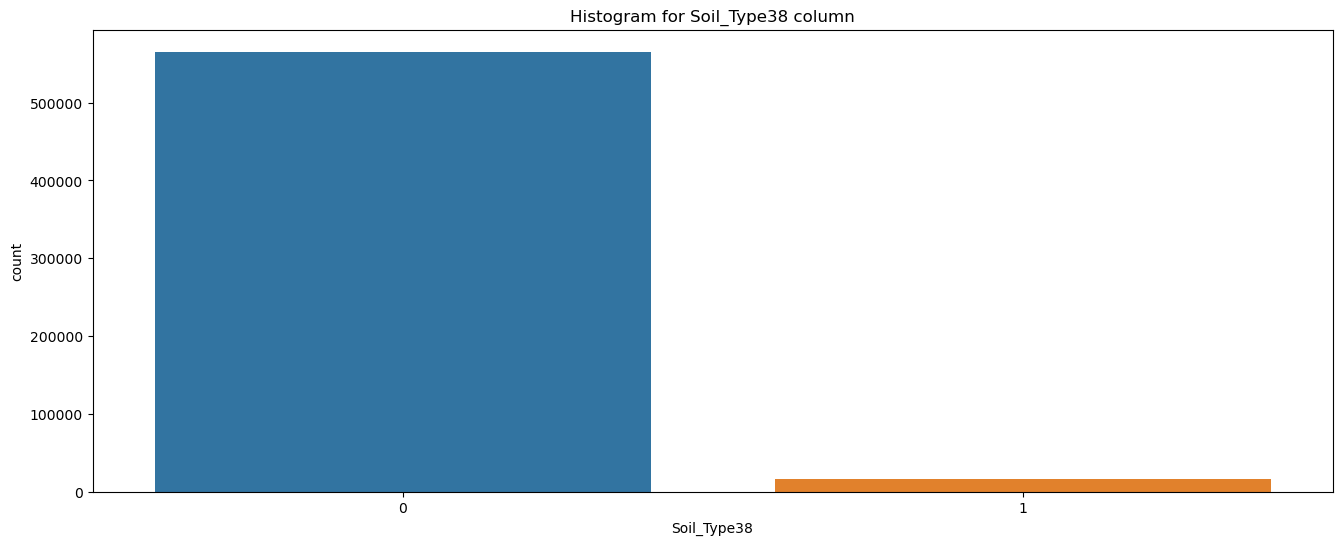

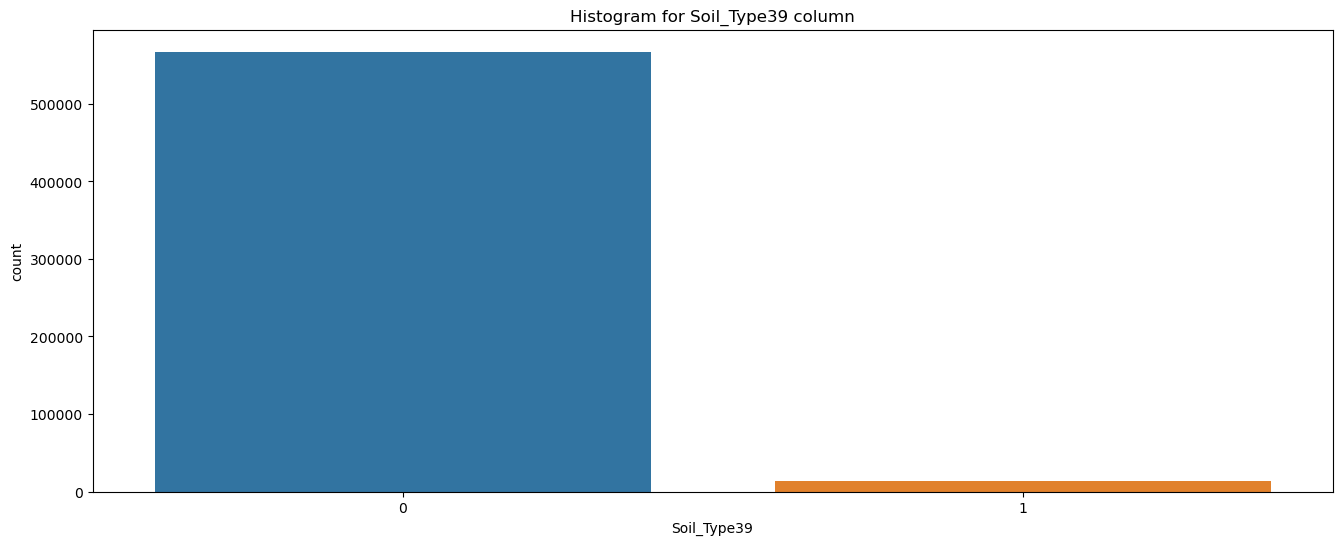

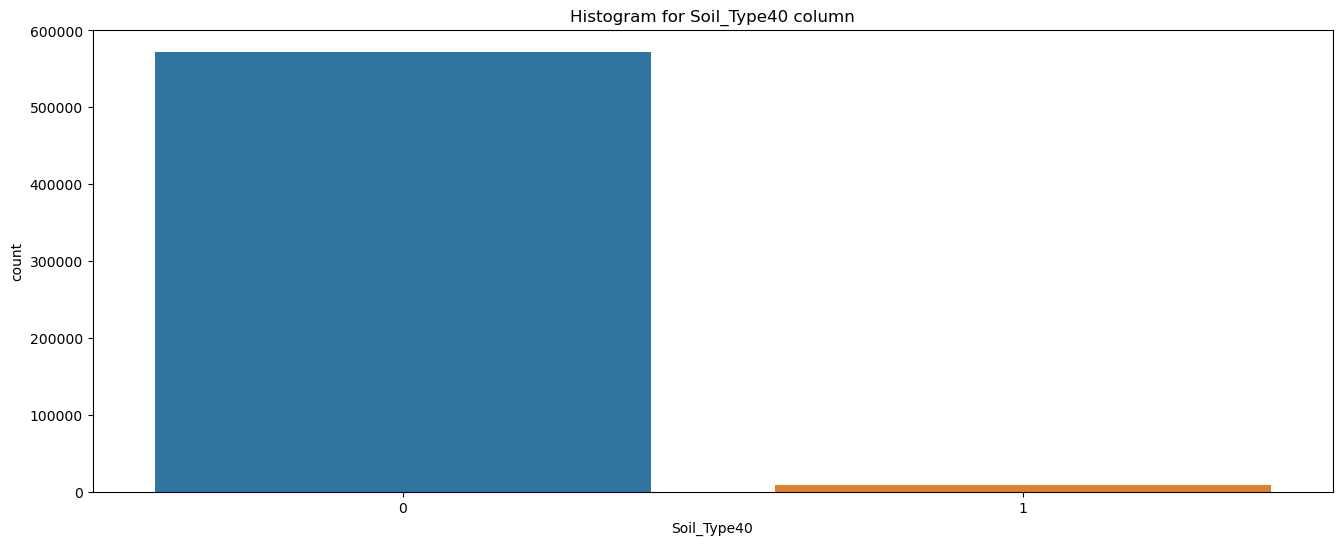

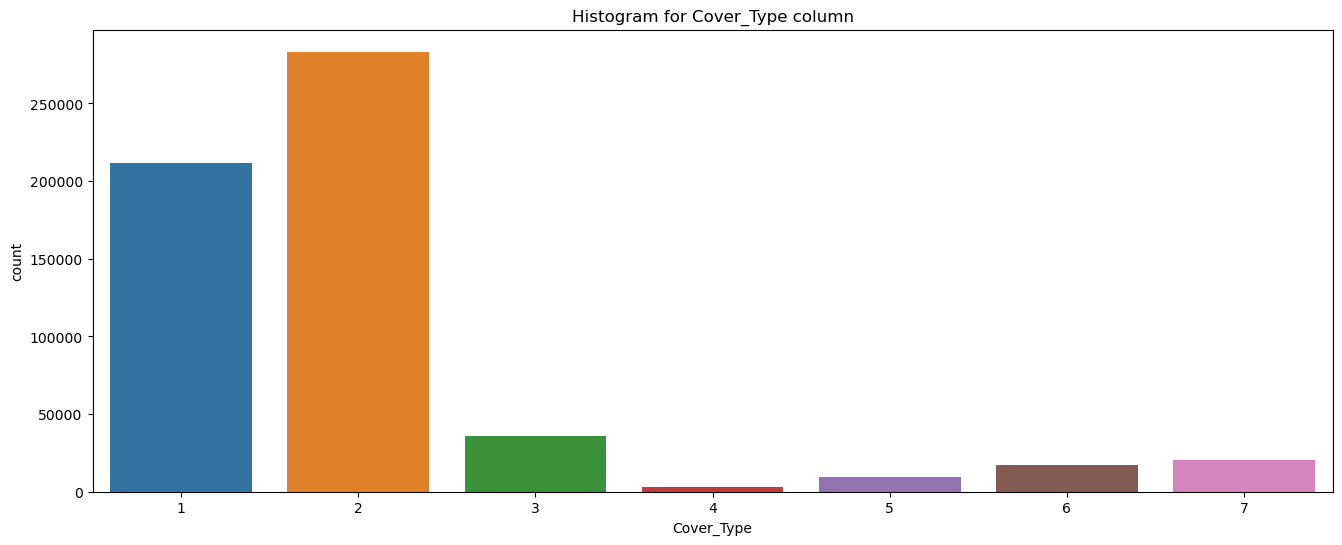

In [22]:
plot_categories_histograms(data=data, columns=categories)

Как видно, большое количество категориальных переменных имеет дисбаланс в сторону негативного класса, что может навредить работе классифицирующих моделей. Поэтому наряду с обычными, использующими все признаки датасета, построим и ряд моделей, работающих только с числовыми данными, и сравним их качество

## Построение классифицирующих моделей

Создадим копию исходного датасета

In [23]:
data_copy = data.copy()

Выделим признаки и целевую переменную

In [24]:
X = data_copy.drop('Cover_Type', axis=1)
X.sample(10)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
29628,3103,0,1,30,0,5243,217,236,156,1307,...,0,0,0,0,0,0,0,0,0,0
550700,3399,82,12,339,66,1132,237,219,111,3923,...,0,0,0,0,1,0,0,0,0,0
156376,2870,352,8,67,8,3037,206,226,158,2689,...,0,0,0,0,0,0,0,0,0,0
436823,3105,13,21,390,68,2644,195,193,130,1266,...,0,0,1,0,0,0,0,0,0,0
284643,2339,350,29,150,100,1338,154,178,152,1092,...,0,0,0,0,0,0,0,0,0,0
525982,3253,55,4,371,66,2016,222,231,145,1855,...,0,1,0,0,0,0,0,0,0,0
234198,2639,268,32,234,115,1065,121,232,240,1440,...,0,0,0,0,0,0,0,0,0,0
93317,2819,335,8,42,-3,3271,202,230,166,2667,...,0,0,0,0,0,0,0,0,0,0
199363,3048,118,5,451,68,1410,228,236,142,2586,...,0,0,0,0,0,0,0,0,0,0
454297,2811,238,6,30,-1,1182,209,245,174,313,...,0,0,0,0,0,0,0,0,0,0


Выделим колонки как массив, что пригодится в дальнейшем

In [25]:
X_columns = X.columns.to_numpy()
X_columns

array(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4',
       'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil

Выделим целевую переменную

In [26]:
y = data_copy.Cover_Type

### Построение модели с учетом категориальных переменных

Разделим данные на тренировочную и тестовую выборки в соотношении 80/20

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((464809, 54), (116203, 54))

Определим число главных компонент

In [28]:
n_components = 10

Построим обычный `ExtraTreesClassifier` с масштабированием

In [29]:
scaled_classic_model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', ExtraTreesClassifier())
])
scaled_classic_model.fit(X_train, y_train)
scaled_classic_model_evaluation,\
    scaled_classic_model_cr,\
    scaled_classic_model_cm = evaluate_model(scaled_classic_model, X_test, y_test)
scaled_classic_model_evaluation

{'macro_f1': 0.926299103834481, 'accuracy': 0.9529960500159205}

In [30]:
print("Классификационный отчет для модели по всем признакам с масштабированием без PCA:\n\n")
print(scaled_classic_model_cr)

Классификационный отчет для модели по всем признакам с масштабированием без PCA:


              precision    recall  f1-score   support

           1       0.96      0.94      0.95     42557
           2       0.95      0.97      0.96     56500
           3       0.95      0.97      0.96      7121
           4       0.92      0.84      0.88       526
           5       0.93      0.78      0.85      1995
           6       0.94      0.91      0.92      3489
           7       0.97      0.96      0.96      4015

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.93    116203
weighted avg       0.95      0.95      0.95    116203



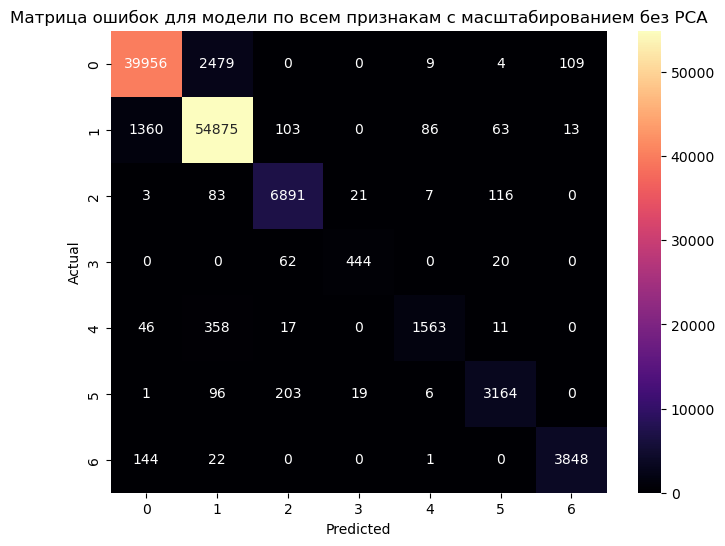

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(scaled_classic_model_cm, annot=True, fmt='d', cmap='magma', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Матрица ошибок для модели по всем признакам с масштабированием без PCA')
plt.show()

Как видно, модель показала достаточно высокое качество, что говорит об информативности всех признаков, даже скошено распределенных категорий. Посмотрим, как повлияет уменьшение размерности данных и исключение категорий на качество модели

Построим `ExtraTreesClassifier` с PCA и масштабированием

In [32]:
scaled_pca_model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=n_components)),
    ('clf', ExtraTreesClassifier())
])
scaled_pca_model.fit(X_train, y_train)
scaled_pca_model_evaluation,\
    scaled_pca_model_cr,\
    scaled_pca_model_cm = evaluate_model(scaled_pca_model, X_test, y_test)
scaled_pca_model_evaluation

{'macro_f1': 0.8972307214380036, 'accuracy': 0.9381771554951249}

In [33]:
print("Классификационный отчет для модели по всем признакам с масштабированием и PCA:\n\n")
print(scaled_pca_model_cr)

Классификационный отчет для модели по всем признакам с масштабированием и PCA:


              precision    recall  f1-score   support

           1       0.95      0.93      0.94     42557
           2       0.94      0.96      0.95     56500
           3       0.92      0.95      0.93      7121
           4       0.88      0.75      0.81       526
           5       0.90      0.75      0.82      1995
           6       0.90      0.87      0.88      3489
           7       0.96      0.95      0.95      4015

    accuracy                           0.94    116203
   macro avg       0.92      0.88      0.90    116203
weighted avg       0.94      0.94      0.94    116203



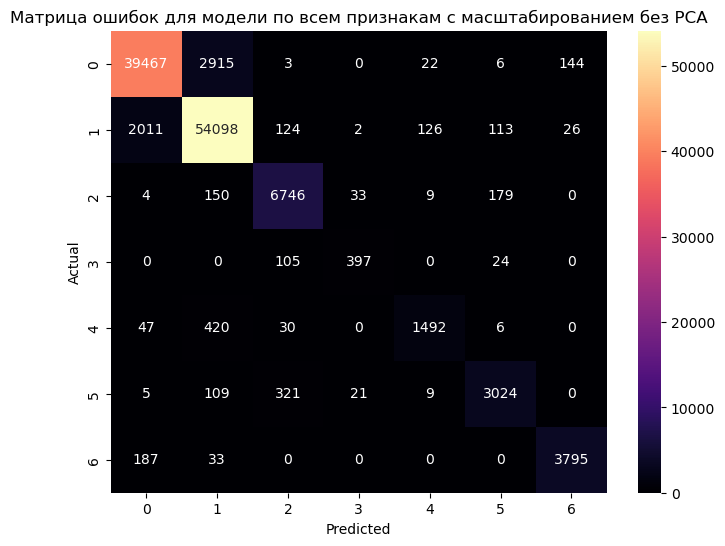

In [34]:
plt.figure(figsize=(8, 6))
sns.heatmap(scaled_pca_model_cm, annot=True, fmt='d', cmap='magma', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Матрица ошибок для модели по всем признакам с масштабированием без PCA')
plt.show()

Как видим, метрики модели просели примерно на 3%, что говорит о том, что хоть уменьшение размерности данных и ухудшает работу модели, однако это не так глобально и потенциальное преимущество, полученное от сокращения использования ресурсов может уравновесить такую потерю в качестве

Построим график куммулятивного описания дисперсии

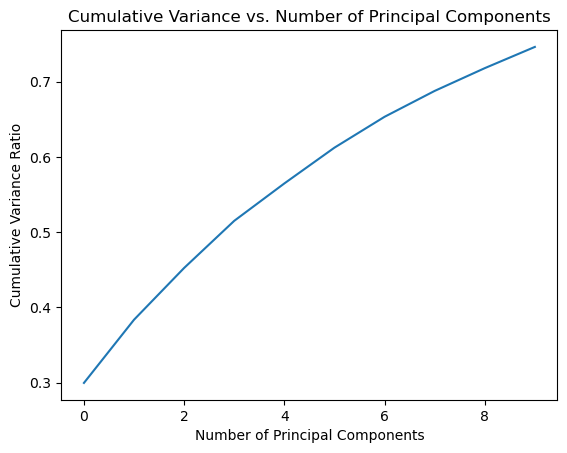

In [35]:
plot_pca_cumulative_variance(scaled_pca_model.named_steps['pca'].explained_variance_ratio_)

Матрица весов главных компонент имеет вид:

In [36]:
report = generate_pca_report(scaled_pca_model.named_steps['pca'], columns=X_columns)
report

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0.011684,-0.061603,-0.031488,-0.022245,-0.018735,0.125256,0.026861,-0.000836,-0.026155,0.096731,...,-0.061284,-0.132192,-0.111672,-0.003593,-0.000537,-0.000273,0.000358,0.000841,-0.001013,0.002378
1,-0.165571,0.127253,0.047058,-0.075387,-0.006900,-0.202661,-0.053270,-0.023389,0.027705,-0.091130,...,-0.058652,-0.159612,-0.110948,-0.003127,0.001619,-0.000323,-0.000034,0.006899,0.001646,0.010505
2,-0.147394,0.315644,0.099217,0.012378,0.032530,-0.070573,-0.112075,-0.020533,0.092514,-0.099286,...,-0.004383,-0.001578,0.010741,0.000343,-0.004078,-0.000040,-0.001243,-0.032974,-0.025941,-0.018111
3,-0.141445,-0.796117,0.060767,-0.019422,0.005240,-0.159507,0.156745,-0.117287,-0.320022,-0.012813,...,0.018426,-0.113054,0.073358,-0.001039,0.002281,-0.000101,0.001037,-0.026158,-0.008938,-0.004976
4,0.006978,-0.154306,-0.015363,-0.063914,-0.032622,-0.087447,0.025437,-0.015810,-0.042701,-0.072796,...,0.004602,-0.290491,0.039531,-0.000722,-0.000244,-0.000080,-0.000654,-0.038802,-0.034384,-0.015469
5,0.042945,-0.170593,-0.103850,0.014907,-0.026435,-0.083137,0.063724,0.020289,-0.032667,-0.023120,...,-0.056323,0.741690,-0.545644,-0.002360,0.002007,-0.000165,-0.000087,-0.010986,-0.019712,0.003021
6,0.201502,-0.062425,0.008572,0.111067,0.032133,-0.088225,0.030197,-0.007530,-0.043729,0.054244,...,-0.092857,0.058297,0.414203,-0.002947,0.009552,-0.000085,-0.000004,0.043330,0.012815,0.054714
7,0.059733,-0.048398,-0.017298,-0.042738,-0.027915,0.040413,0.000530,0.002969,0.008167,-0.060677,...,0.297335,-0.372219,-0.551601,0.005357,0.004720,0.000427,0.000306,0.046463,0.034912,0.015050
8,-0.039764,-0.000591,-0.100337,0.071523,0.002371,-0.007320,-0.019294,0.036309,0.083020,0.243620,...,0.120984,-0.096899,-0.078308,0.001256,0.001942,0.000063,-0.000376,0.014398,-0.004545,0.011002
9,0.040505,0.056339,0.032421,0.090446,0.035632,-0.118672,0.009331,-0.002126,-0.019569,0.079454,...,0.359551,-0.181249,-0.228061,0.002970,0.008917,0.000261,-0.000157,0.073069,0.049538,0.059192


Информация о важности переменных в рамках каждой компоненты:

In [37]:
print_pca_components_with_feature_importance(pca=scaled_pca_model.named_steps['pca'], report=report)

Top features for PCA Component 1:
Wilderness_Area1                      0.646611
Wilderness_Area3                      0.613076
Soil_Type29                           0.352000
Soil_Type32                           0.132192
Horizontal_Distance_To_Roadways       0.125256
Soil_Type33                           0.111672
Horizontal_Distance_To_Fire_Points    0.096731
Soil_Type12                           0.065068
Soil_Type30                           0.063333
Aspect                                0.061603
Soil_Type31                           0.061284
Soil_Type10                           0.047024
Soil_Type13                           0.041219
Soil_Type24                           0.033326
Slope                                 0.031488
Soil_Type11                           0.027492
Soil_Type4                            0.026957
Hillshade_9am                         0.026861
Hillshade_3pm                         0.026155
Horizontal_Distance_To_Hydrology      0.022245
Wilderness_Area4          

Объяснение дисперсии данных компонентами

In [38]:
for i in range(len(scaled_pca_model.named_steps['pca'].explained_variance_ratio_)):
    print(f"PC{i+1} объясняет {scaled_pca_model.named_steps['pca'].explained_variance_ratio_[i]*100:.2f}% дисперсии данных")

PC1 объясняет 29.97% дисперсии данных
PC2 объясняет 8.40% дисперсии данных
PC3 объясняет 6.88% дисперсии данных
PC4 объясняет 6.26% дисперсии данных
PC5 объясняет 4.97% дисперсии данных
PC6 объясняет 4.75% дисперсии данных
PC7 объясняет 4.10% дисперсии данных
PC8 объясняет 3.44% дисперсии данных
PC9 объясняет 3.02% дисперсии данных
PC10 объясняет 2.82% дисперсии данных


## Построение моделей без учета категориальных переменных

Исключим целевую переменную из списка категорий

In [39]:
categories.remove('Cover_Type')

Создадим фрейм, состоящий чисто из числовых признаков

In [40]:
X_without_categories = X.drop(categories, axis=1)
X_without_categories.sample(10)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
266737,2195,335,33,170,89,1187,129,177,176,1087
245610,2049,115,36,324,144,335,254,181,22,785
420853,3320,203,28,277,86,984,193,251,176,939
165558,3190,61,19,591,115,4349,232,197,89,3277
133851,2927,72,12,417,63,2989,233,217,114,2457
235876,2609,116,39,85,44,1740,252,171,7,1256
83210,2952,263,12,426,52,5497,189,246,196,4447
203926,3030,315,3,95,2,1276,212,237,163,2671
193147,3027,11,11,390,65,1342,209,218,146,2415
377031,2782,354,6,553,104,2825,209,229,158,1492


Опять выделим колонки как массив, что пригодится в дальнейшем

In [41]:
X_columns_numeric = X_without_categories.columns.to_numpy()
X_columns_numeric

array(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am',
       'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points'], dtype=object)

Разделим данные на тренировочную и тестовую выборки в соотношении 80/20

In [42]:
X_train_numeric, X_test_numeric, y_train_numeric, y_test_numeric = train_test_split(X_without_categories.values, 
                                                                                    y, test_size=0.2, random_state=42)
X_train_numeric.shape, X_test_numeric.shape

((464809, 10), (116203, 10))

Построим обычный `ExtraTreesClassifier` с масштабированием, но без учета категориальных переменных

In [43]:
scaled_numeric_model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', ExtraTreesClassifier())
])
scaled_numeric_model.fit(X_train_numeric, y_train_numeric)
scaled_numeric_model_evaluation,\
    scaled_numeric_model_cr,\
    scaled_numeric_model_cm = evaluate_model(scaled_numeric_model, X_test_numeric, y_test_numeric)
scaled_numeric_model_evaluation

{'macro_f1': 0.9144419552420288, 'accuracy': 0.9475486863506105}

In [44]:
print("Классификационный отчет для модели по числовым признакам с масштабированием без PCA:\n\n")
print(scaled_numeric_model_cr)

Классификационный отчет для модели по числовым признакам с масштабированием без PCA:


              precision    recall  f1-score   support

           1       0.95      0.94      0.95     42557
           2       0.94      0.97      0.95     56500
           3       0.94      0.95      0.95      7121
           4       0.92      0.82      0.86       526
           5       0.94      0.74      0.83      1995
           6       0.93      0.87      0.90      3489
           7       0.98      0.94      0.96      4015

    accuracy                           0.95    116203
   macro avg       0.94      0.89      0.91    116203
weighted avg       0.95      0.95      0.95    116203



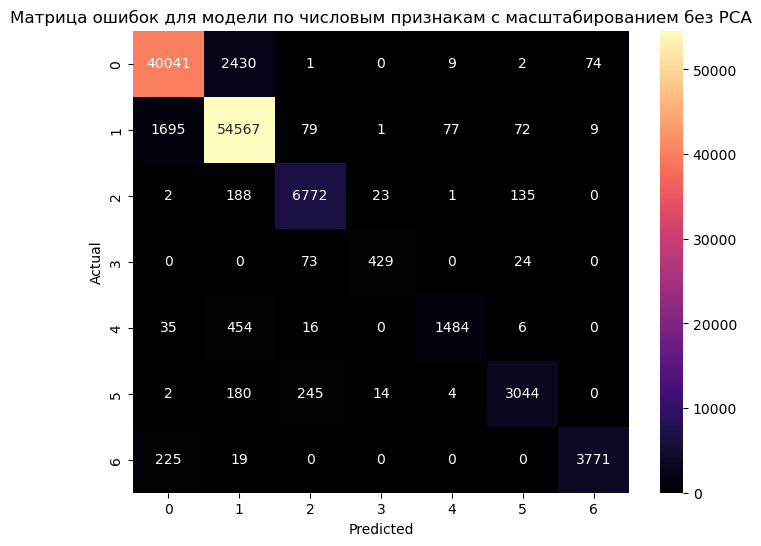

In [45]:
plt.figure(figsize=(8, 6))
sns.heatmap(scaled_numeric_model_cm, annot=True, fmt='d', cmap='magma', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Матрица ошибок для модели по числовым признакам с масштабированием без PCA')
plt.show()

Модель показала себя немного хуже, чем модель, работающая на полных данных и немного лучше модели, использующей сокращение размерности посредством PCA-трансформации, что говорит об относительно малой информативности большинства категориальных признаков в датасете

Построим `ExtraTreesClassifier` с PCA и масштабированием, но без учета категориальных переменных

In [46]:
scaled_numeric_pca_model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=n_components)),
    ('clf', ExtraTreesClassifier())
])
scaled_numeric_pca_model.fit(X_train_numeric, y_train_numeric)
scaled_numeric_pca_model_evaluation,\
    scaled_numeric_pca_model_cr,\
    scaled_numeric_pca_model_cm = evaluate_model(scaled_numeric_pca_model, X_test_numeric, y_test_numeric)
scaled_numeric_pca_model_evaluation

{'macro_f1': 0.8531127894093332, 'accuracy': 0.9101830417459101}

In [47]:
print("Классификационный отчет для модели по числовым признакам с масштабированием и PCA:\n\n")
print(scaled_numeric_pca_model_cr)

Классификационный отчет для модели по числовым признакам с масштабированием и PCA:


              precision    recall  f1-score   support

           1       0.92      0.90      0.91     42557
           2       0.90      0.94      0.92     56500
           3       0.89      0.91      0.90      7121
           4       0.90      0.72      0.80       526
           5       0.93      0.59      0.72      1995
           6       0.88      0.72      0.79      3489
           7       0.97      0.88      0.93      4015

    accuracy                           0.91    116203
   macro avg       0.91      0.81      0.85    116203
weighted avg       0.91      0.91      0.91    116203



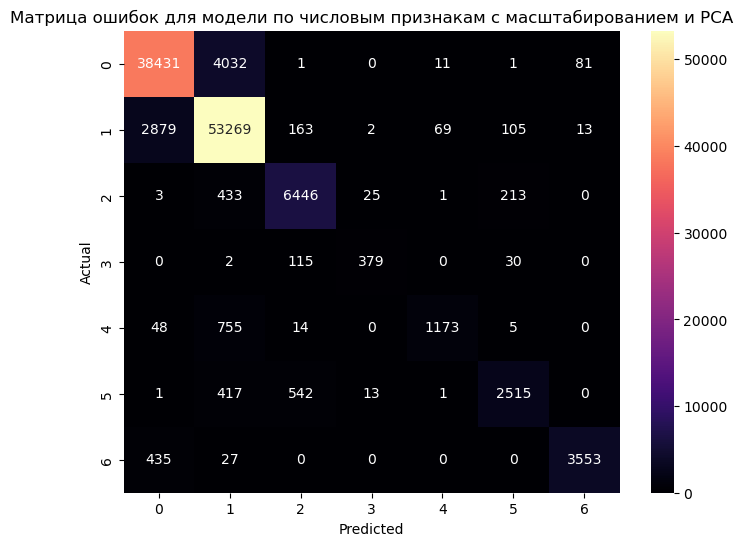

In [48]:
plt.figure(figsize=(8, 6))
sns.heatmap(scaled_numeric_pca_model_cm, annot=True, fmt='d', cmap='magma', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Матрица ошибок для модели по числовым признакам с масштабированием и PCA')
plt.show()

Модель показала себя хуже рассмотренных ранее, однако ее F1-score все равно превышает 0.8, что является хорошим показателем для классифицирующей модели

Построим график куммулятивного описания дисперсии

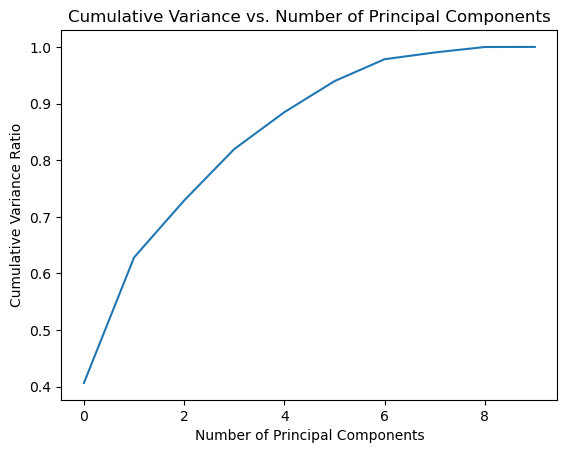

In [49]:
plot_pca_cumulative_variance(scaled_numeric_pca_model.named_steps['pca'].explained_variance_ratio_)

Матрица весов главных компонент имеет вид:

In [50]:
numeric_pca_report = generate_pca_report(scaled_numeric_pca_model.named_steps['pca'], columns=X_columns_numeric)
numeric_pca_report

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
0,0.010442,0.907960,0.020303,0.015967,0.019428,0.027915,-0.210924,0.089762,0.339015,-0.078730
1,0.295898,-0.012335,-0.165464,0.118445,-0.008307,0.801832,0.044092,0.087746,0.074023,0.461258
2,0.396211,-0.068178,0.028718,0.760120,0.272921,-0.004860,-0.006695,0.007319,0.011637,-0.430137
3,0.002120,0.074801,0.018508,0.388864,0.129500,-0.489041,-0.008596,-0.018518,-0.009584,0.765769
4,-0.302502,0.141602,0.664325,0.118520,0.183113,0.290307,-0.104718,-0.371236,-0.404943,0.049974
5,-0.447983,-0.351594,0.082937,0.154428,0.106749,0.113765,-0.490941,0.039991,0.614686,0.012911
6,0.680137,-0.138356,0.418198,-0.331268,-0.033368,-0.140940,-0.375861,-0.175961,0.184813,0.079218
7,0.001704,0.046340,-0.469795,0.133507,-0.336720,0.003247,-0.365818,-0.703194,-0.130435,-0.024700
8,0.023496,0.015909,-0.331561,-0.302090,0.865376,0.002151,-0.066621,-0.206629,-0.043774,0.008535
9,0.003015,-0.000718,-0.131550,0.001531,-0.001415,-0.001396,-0.649559,0.525635,-0.533347,0.000556


Информация о важности переменных в рамках каждой компоненты:

In [51]:
print_pca_components_with_feature_importance(pca=scaled_numeric_pca_model.named_steps['pca'], report=numeric_pca_report)

Top features for PCA Component 1:
Aspect                                0.907960
Hillshade_3pm                         0.339015
Hillshade_9am                         0.210924
Hillshade_Noon                        0.089762
Horizontal_Distance_To_Fire_Points    0.078730
Horizontal_Distance_To_Roadways       0.027915
Slope                                 0.020303
Vertical_Distance_To_Hydrology        0.019428
Horizontal_Distance_To_Hydrology      0.015967
Elevation                             0.010442
Name: 0, dtype: float64

Top features for PCA Component 2:
Horizontal_Distance_To_Roadways       0.801832
Horizontal_Distance_To_Fire_Points    0.461258
Elevation                             0.295898
Slope                                 0.165464
Horizontal_Distance_To_Hydrology      0.118445
Hillshade_Noon                        0.087746
Hillshade_3pm                         0.074023
Hillshade_9am                         0.044092
Aspect                                0.012335
Vertical_Dista

Объяснение дисперсии данных компонентами

In [52]:
for i in range(len(scaled_numeric_pca_model.named_steps['pca'].explained_variance_ratio_)):
    print(f"PC{i+1} объясняет {scaled_numeric_pca_model.named_steps['pca'].explained_variance_ratio_[i]*100:.2f}% "
          f"дисперсии данных")

PC1 объясняет 40.66% дисперсии данных
PC2 объясняет 22.16% дисперсии данных
PC3 объясняет 10.05% дисперсии данных
PC4 объясняет 9.08% дисперсии данных
PC5 объясняет 6.52% дисперсии данных
PC6 объясняет 5.48% дисперсии данных
PC7 объясняет 3.87% дисперсии данных
PC8 объясняет 1.19% дисперсии данных
PC9 объясняет 0.97% дисперсии данных
PC10 объясняет 0.02% дисперсии данных


Как видно, компоненты описывают всю дисперсию данных, если мы возьмем только числовые признаки, что говорит о возможной необходимости использовать меньшее число компонент при анализе одних числовых признаков

## Финальное сравнение построенных моделей

Создадим датафрейм с данными о качестве рассматриваемых моделей

In [53]:
all_models = [
    'scaled_classic_model',
    'scaled_pca_model',
    'scaled_numeric_model',
    'scaled_numeric_pca_model'
]
all_models

['scaled_classic_model',
 'scaled_pca_model',
 'scaled_numeric_model',
 'scaled_numeric_pca_model']

In [54]:
all_evaluations = [
    scaled_classic_model_evaluation,
    scaled_pca_model_evaluation,
    scaled_numeric_model_evaluation,
    scaled_numeric_pca_model_evaluation
]

all_evaluations

[{'macro_f1': 0.926299103834481, 'accuracy': 0.9529960500159205},
 {'macro_f1': 0.8972307214380036, 'accuracy': 0.9381771554951249},
 {'macro_f1': 0.9144419552420288, 'accuracy': 0.9475486863506105},
 {'macro_f1': 0.8531127894093332, 'accuracy': 0.9101830417459101}]

In [55]:
models_report = pd.DataFrame(all_evaluations, index=all_models)
models_report

,macro_f1,accuracy
scaled_classic_model,0.926299,0.952996
scaled_pca_model,0.897231,0.938177
scaled_numeric_model,0.914442,0.947549
scaled_numeric_pca_model,0.853113,0.910183


Как видно, лучший результат показала модель, использующая все данные без применения PCA-трансформации

Немного уступили по качеству модели, использующие PCA-трансформацию на полном наборе данных и модель, работающая только с числовыми признаками. Это говорит о том, что при сильной ограниченности ресурсов можно пренебречь некоторыми признаками, однако такие действия приведут к снижению качества новых моделей, поскольку все признаки обладают информационной ценностью